In [ ]:
"""
06_victor_felipe_mendez_2026.ipynb
Cell 1 — Setup
Imports, pydoll helper (go_to API URL -> read page_source),
output path and constants.
"""
import asyncio
import json
import time
import urllib.parse
from pathlib import Path

import nest_asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import VerticalPitch

from pydoll.browser.chromium import Chrome
from pydoll.browser.options import ChromiumOptions

nest_asyncio.apply()

# ── Constants ────────────────────────────────────────────────────────────────
PLAYER_NAME   = "Víctor Felipe Méndez"
TEAM          = "Colo-Colo"
SEASON        = "2026"
BASE_URL      = "https://api.sofascore.com/api/v1"

OUTPUT_PATH   = Path("../outputs/victor_felipe_mendez")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# ── pydoll helper: navigate to API URL and read JSON from page source ─────────
async def _fetch_json(url: str) -> dict:
    options = ChromiumOptions()
    options.headless = True
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    async with Chrome(options=options) as browser:
        tab = await browser.start()
        # Warm up session on main SofaScore page
        await tab.go_to("https://www.sofascore.com")
        await asyncio.sleep(3)
        # Navigate directly to the API endpoint — browser returns raw JSON
        await tab.go_to(url)
        await asyncio.sleep(2)
        src = await tab.page_source
        # page_source may wrap JSON in <html><body><pre>...</pre></body></html>
        text = src
        if "<pre" in src:
            import re
            m = re.search(r"<pre[^>]*>(.*?)</pre>", src, re.DOTALL)
            text = m.group(1) if m else src
        return json.loads(text)

def fetch(url: str) -> dict:
    data = asyncio.run(_fetch_json(url))
    time.sleep(1)
    return data

print("Setup complete.")
print(f"  Player : {PLAYER_NAME}  ({TEAM})")
print(f"  Output : {OUTPUT_PATH.resolve()}")


Setup complete.
  Player : Víctor Felipe Méndez  (Colo-Colo)
  Output : C:\Users\PC\Projects\CaciqueAnalytics\outputs\victor_felipe_mendez


In [ ]:
"""
Cell 2 — Find player_id for Mendez reusing the same LanusStats endpoint
(scrape_league_stats uses /unique-tournament/{id}/season/{id}/statistics with
base_url = https://www.sofascore.com/). Same approach but preserving the
player id field that LanusStats discards.
"""
import asyncio, json, re, time
import nest_asyncio
nest_asyncio.apply()
from pydoll.browser.chromium import Chrome
from pydoll.browser.options import ChromiumOptions

TOURNAMENT_ID = 11653
SEASON_ID     = 88493
SS_BASE       = "https://www.sofascore.com/"

# Concatenated fields (same as LanusStats)
fields = "minutesPlayed%2CaccuratePasses%2CkeyPasses%2CbigChancesCreated%2Cassists%2Cinterceptions%2CsuccessfulDribbles"
positions = "M"  # midfielders only

async def _go_to_json(url: str) -> dict:
    options = ChromiumOptions()
    options.headless = True
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    async with Chrome(options=options) as browser:
        tab = await browser.start()
        await tab.go_to("https://www.sofascore.com")
        await asyncio.sleep(3)
        await tab.go_to(url)
        await asyncio.sleep(2)
        src = await tab.page_source
        if "<pre" in src:
            m = re.search(r"<pre[^>]*>(.*?)</pre>", src, re.DOTALL)
            src = m.group(1) if m else src
        return json.loads(src)

def go_fetch(url: str) -> dict:
    return asyncio.run(_go_to_json(url))

# Paginate until we find Mendez (max 5 pages = 500 players)
PLAYER_ID = None
for offset in range(0, 500, 100):
    url = (f"{SS_BASE}api/v1/unique-tournament/{TOURNAMENT_ID}/season/{SEASON_ID}/statistics"
           f"?limit=100&order=-minutesPlayed&offset={offset}"
           f"&accumulation=total&fields={fields}&filters=position.in.{positions}")
    print(f"Fetching offset={offset} ...")
    data = go_fetch(url)
    results = data.get("results", [])
    print(f"  Got {len(results)} rows")

    for r in results:
        p    = r.get("player", {})
        name = p.get("name", "")
        pid  = p.get("id")
        team = r.get("team", {}).get("name", "-") if isinstance(r.get("team"), dict) else "-"
        if "mendez" in name.lower() or "méndez" in name.lower():
            print(f"  Found: ID={pid}  name='{name}'  team='{team}'")
            PLAYER_ID = pid

    if data.get("page") == data.get("pages") or not results:
        print("  End of pages.")
        break

if PLAYER_ID:
    print(f"\nPLAYER_ID = {PLAYER_ID}")
else:
    print("\nNot found — printing all midfielders:")
    for r in results:
        p = r.get("player", {})
        print(f"  {p.get('id', '?'):<10} {p.get('name', '?'):<35} {r.get('team',{}).get('name','')}")


Fetching offset=0 …
  Got 100 rows
  Found: ID=870020  name='Víctor Felipe Méndez'  team='Colo-Colo'
  Found: ID=787710  name='Kevin Méndez'  team='Unión La Calera'
Fetching offset=100 …
  Got 34 rows
  End of pages.

PLAYER_ID = 787710


In [ ]:
"""
Cell 3 — Confirmed player ID
Victor Felipe Mendez (Colo-Colo) = 870020
Kevin Mendez (Union La Calera)   = 787710
"""
PLAYER_ID     = 870020
TOURNAMENT_ID = 11653
SEASON_ID     = 88493
SS_BASE       = "https://www.sofascore.com/"

print(f"Player : {PLAYER_NAME}  (ID={PLAYER_ID})")
print(f"League : Chile Primera Division  (tournament={TOURNAMENT_ID}, season={SEASON_ID})")


Player : Víctor Felipe Méndez  (ID=870020)
League : Chile Primera División  (tournament=11653, season=88493)


In [ ]:
"""
Cell 4 — Fetch season heatmap
Endpoint: /player/{id}/unique-tournament/{tid}/season/{sid}/heatmap/overall
Returns a list of points {x, y} (scale 0-100).
"""
url = (f"{SS_BASE}api/v1/player/{PLAYER_ID}"
       f"/unique-tournament/{TOURNAMENT_ID}/season/{SEASON_ID}/heatmap/overall")

print(f"Fetching: {url}\n")
raw = go_fetch(url)

print("Response keys:", list(raw.keys()))
points = raw.get("points", raw.get("heatmap", []))
print(f"Total points: {len(points)}")
if points:
    print("Sample (first 3):", points[:3])

# Save raw JSON
raw_path = OUTPUT_PATH / f"{PLAYER_NAME.replace(' ','_')}_heatmap_raw.json"
raw_path.write_text(json.dumps(raw, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"\nRaw JSON saved -> {raw_path.name}")


Fetching: https://www.sofascore.com/api/v1/player/870020/unique-tournament/11653/season/88493/heatmap/overall

Response keys: ['points', 'matches', 'events']
Total points: 321
Sample (first 3): [{'x': 35, 'y': 59, 'count': 1}, {'x': 35, 'y': 66, 'count': 2}, {'x': 35, 'y': 62, 'count': 1}]

Raw JSON saved -> Víctor_Felipe_Méndez_heatmap_raw.json


In [ ]:
"""
Cell 5b — Full pass scraping + per-match statistics (v3)
- rating-breakdown  -> coordinates for accurate passes and key passes
- statistics        -> totalPass, accuratePass (to derive inaccurate count),
                       goalAssist, keyPass, rating
NOTE: Inaccurate pass coordinates are not available via the public SofaScore API,
but the real counts are captured here from the statistics endpoint.
"""
import re as _re

PASS_CACHE   = OUTPUT_PATH / f"{SLUG}_passes_raw.json"
STATS_CACHE  = OUTPUT_PATH / f"{SLUG}_match_stats.json"

# Force re-scraping by deleting old caches
for _c in [PASS_CACHE, STATS_CACHE]:
    if _c.exists():
        _c.unlink()
        print(f"Cache deleted: {_c.name}")

# ── 1. Get match list ─────────────────────────────────────────────────────────
match_ids = []
for page in range(0, 5):
    url_ev = f"{SS_BASE}api/v1/player/{PLAYER_ID}/events/last/{page}"
    try:
        data_ev = go_fetch(url_ev)
    except Exception as e:
        print(f"  Page {page} error: {e}")
        break
    events = data_ev.get("events", [])
    if not events:
        break
    for ev in events:
        tid_     = ev.get("tournament", {}).get("uniqueTournament", {}).get("id")
        seas_id_ = ev.get("season", {}).get("id")
        if tid_ == TOURNAMENT_ID and seas_id_ == SEASON_ID:
            match_ids.append(ev["id"])
    print(f"  Page {page}: {len(events)} events, {len(match_ids)} PD2026 matches so far.")
    if data_ev.get("hasNextPage") is False:
        break

match_ids = list(dict.fromkeys(match_ids))
print(f"\nPD 2026 matches: {len(match_ids)}  ->  {match_ids}")

# ── 2. Scrape rating-breakdown + statistics per match ─────────────────────────
all_passes   = []   # list of dicts with coordinates (accurate passes only)
match_stats  = {}   # dict[match_id] -> full stats

for mid in match_ids:

    # ── 2a. Coordinates (rating-breakdown) ───────────────────────────────────
    url_rb = f"{SS_BASE}api/v1/event/{mid}/player/{PLAYER_ID}/rating-breakdown"
    rb = go_fetch(url_rb)

    for p in rb.get("passes", []):
        pc  = p.get("playerCoordinates", {})
        pe_ = p.get("passEndCoordinates", {})
        if pc and pe_:
            all_passes.append({
                "match_id": mid,
                "x":        pc.get("x"),
                "y":        pc.get("y"),
                "end_x":    pe_.get("x"),
                "end_y":    pe_.get("y"),
                "accurate": bool(p.get("outcome", True)),
                "keypass":  bool(p.get("keypass", False)),
            })

    # ── 2b. Aggregated statistics (statistics endpoint) ───────────────────────
    url_st = f"{SS_BASE}api/v1/event/{mid}/player/{PLAYER_ID}/statistics"
    st = go_fetch(url_st).get("statistics", {})

    total   = int(st.get("totalPass",    0))
    acc     = int(st.get("accuratePass", 0))
    inacc   = total - acc
    assists = int(st.get("goalAssist",   0))
    kp      = int(st.get("keyPass",      0))
    rating  = float(st.get("rating",     0))
    mins    = int(st.get("minutesPlayed",0))

    match_stats[mid] = {
        "totalPass":      total,
        "accuratePass":   acc,
        "inaccuratePass": inacc,
        "goalAssist":     assists,
        "keyPass":        kp,
        "rating":         rating,
        "minutesPlayed":  mins,
    }

    acc_pct = round(acc / total * 100, 1) if total else 0
    print(f"  match {mid}: {total} passes ({acc_pct}% acc)  "
          f"inacc={inacc}  kp={kp}  ast={assists}  rating={rating}")

# ── Save caches ───────────────────────────────────────────────────────────────
PASS_CACHE.write_text(json.dumps(all_passes, ensure_ascii=False), encoding="utf-8")
STATS_CACHE.write_text(json.dumps(match_stats, ensure_ascii=False, default=str), encoding="utf-8")

print(f"\nTotal passes (with coords): {len(all_passes)}")
print(f"Saved: {PASS_CACHE.name}  +  {STATS_CACHE.name}")

# ── Season summary ────────────────────────────────────────────────────────────
tot_passes  = sum(v["totalPass"]      for v in match_stats.values())
tot_acc     = sum(v["accuratePass"]   for v in match_stats.values())
tot_inacc   = sum(v["inaccuratePass"] for v in match_stats.values())
tot_assists = sum(v["goalAssist"]     for v in match_stats.values())
tot_kp      = sum(v["keyPass"]        for v in match_stats.values())
tot_mins    = sum(v["minutesPlayed"]  for v in match_stats.values())
avg_rating  = round(sum(v["rating"]   for v in match_stats.values()) / len(match_stats), 2)

print(f"\n{'='*50}")
print(f"  VICTOR FELIPE MENDEZ — PD 2026 ({len(match_ids)} matches, {tot_mins} min)")
print(f"  Total passes:    {tot_passes}")
print(f"  Accurate:        {tot_acc}  ({round(tot_acc/tot_passes*100,1) if tot_passes else 0}%)")
print(f"  Inaccurate:      {tot_inacc}")
print(f"  Assists:         {tot_assists}")
print(f"  Key passes:      {tot_kp}")
print(f"  Avg rating:      {avg_rating}")
print(f"{'='*50}")


Caché eliminado: Víctor_Felipe_Méndez_passes_raw.json
  Page 0: 30 events, 4 PD2026 matches so far.
  Page 1: 30 events, 4 PD2026 matches so far.
  Page 2: 30 events, 4 PD2026 matches so far.
  Page 3: 30 events, 4 PD2026 matches so far.
  Page 4: 30 events, 4 PD2026 matches so far.

PD 2026 matches: 4  ->  [15352965, 15352976, 15352957, 15352970]
  match 15352965: 93 passes (92.5% acc)  inacc=7  kp=3  ast=0  rating=7.4
  match 15352976: 46 passes (93.5% acc)  inacc=3  kp=6  ast=1  rating=8.2
  match 15352957: 64 passes (92.2% acc)  inacc=5  kp=4  ast=0  rating=7.3
  match 15352970: 55 passes (87.3% acc)  inacc=7  kp=3  ast=0  rating=6.7

Total passes (with coords): 264
Saved: Víctor_Felipe_Méndez_passes_raw.json  +  Víctor_Felipe_Méndez_match_stats.json

══════════════════════════════════════════════════
  VICTOR FELIPE MENDEZ — PD 2026 (4 matches, 360 min)
  Total passes:    258
  Accurate:        236  (91.5%)
  Inaccurate:      22
  Assists:         1
  Key passes:      16
  Avg rat

In [ ]:
"""
Cell 5c — Quick diagnostic: full statistics for one match
"""
import json as _json

_mid   = match_ids[0]
_url_s = f"{SS_BASE}api/v1/event/{_mid}/player/{PLAYER_ID}/statistics"
_st    = go_fetch(_url_s)

print("=== FULL STATISTICS ===")
for k, v in _st.get("statistics", {}).items():
    print(f"  {k}: {v}")

print(f"\n  Inferred inaccurate: totalPass({_st['statistics'].get('totalPass',0)}) - "
      f"accuratePass({_st['statistics'].get('accuratePass',0)}) = "
      f"{_st['statistics'].get('totalPass',0) - _st['statistics'].get('accuratePass',0)}")


=== statistics COMPLETO ===
  totalPass: 93
  accuratePass: 86
  totalLongBalls: 4
  accurateLongBalls: 3
  goalAssist: 0
  accurateOwnHalfPasses: 19
  totalOwnHalfPasses: 19
  accurateOppositionHalfPasses: 67
  totalOppositionHalfPasses: 74
  totalCross: 1
  aerialLost: 1
  duelLost: 2
  duelWon: 7
  totalContest: 5
  wonContest: 4
  shotOffTarget: 1
  onTargetScoringAttempt: 1
  blockedScoringAttempt: 1
  hitWoodwork: 1
  ballRecovery: 11
  totalTackle: 3
  wonTackle: 2
  unsuccessfulTouch: 3
  minutesPlayed: 90
  touches: 109
  rating: 7.4
  possessionLostCtrl: 12
  totalBallCarriesDistance: 333.85182597955
  ballCarriesCount: 37
  totalProgression: 168.01384196239
  bestBallCarryProgression: 26.826172019738
  totalProgressiveBallCarriesDistance: 41.162343418655
  progressiveBallCarriesCount: 2
  keyPass: 3
  ratingVersions: {'original': 7.4, 'alternative': 7.9}
  totalShots: 3
  shotValueNormalized: -0.38
  passValueNormalized: 0.39
  dribbleValueNormalized: 0.37
  defensiveValueNo

Available passes: 264
Total connections: 58  ->  filtered (>=3): 28
Saved -> Víctor_Felipe_Méndez_2026_magazine_2100x1200.png  (205.0 KB)
  Dimensiones reales: 2036 x 1177 px


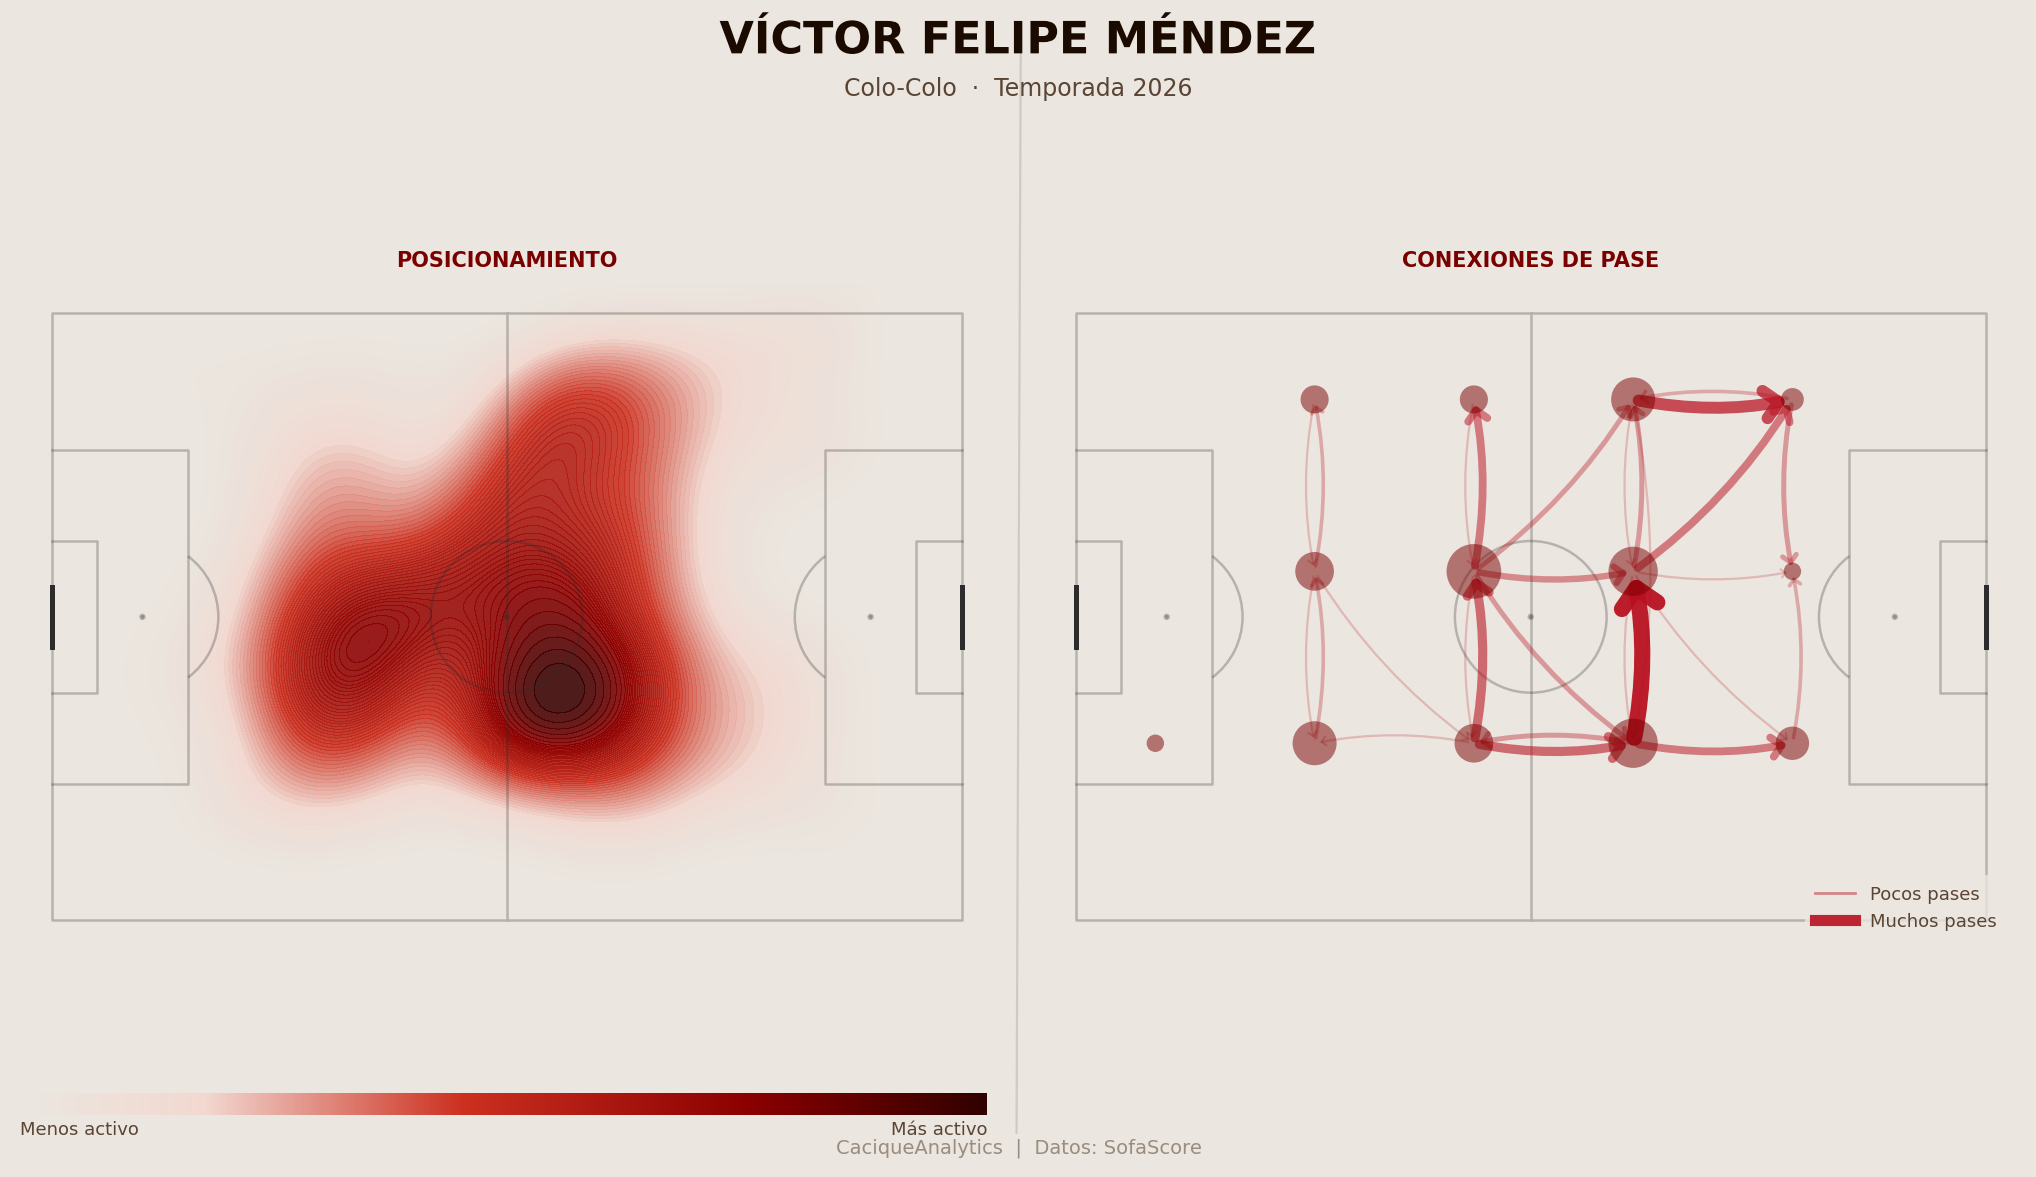

In [ ]:
"""
Cell 6 — Combined 2100x1200 magazine image (v3)
Left  : Position heatmap (KDE)
Right : Zone pass network — only connections with >= 3 passes
"""
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from mplsoccer import Pitch

# ── Color palette ─────────────────────────────────────────────────────────────
BG      = "#EBE6DF"
LINE_C  = "#2C2C2C"
LINE_A  = 0.28
RED_D   = "#7A0000"
RED_M   = "#B81020"
TITLE_C = "#1A0A00"
SUB_C   = "#5A4535"
FOOT_C  = "#9A8C7E"

CMAP_HEAT = LinearSegmentedColormap.from_list(
    "mag_heat",
    [(0.00, BG), (0.18, "#F2D8D0"), (0.45, "#CC3020"),
     (0.75, "#8B0000"), (1.00, "#300000")],
    N=512,
)

# ── Parse passes ──────────────────────────────────────────────────────────────
df_passes = pd.DataFrame(all_passes) if all_passes else pd.DataFrame(
    columns=["x","y","end_x","end_y"]
)
for col, f in [("x",105),("y",68),("end_x",105),("end_y",68)]:
    if col in df_passes.columns:
        df_passes[col] = pd.to_numeric(df_passes[col], errors="coerce") / 100 * f
df_passes = df_passes.dropna(subset=["x","y","end_x","end_y"])
print(f"Available passes: {len(df_passes)}")

# ── Pass network: 5x3 grid, threshold = 3 passes ─────────────────────────────
COLS_Z, ROWS_Z = 5, 3
DX, DY         = 105 / COLS_Z, 68 / ROWS_Z

def to_zone(x, y):
    return (min(int(x // DX), COLS_Z-1), min(int(y // DY), ROWS_Z-1))

def zone_centre(c, r):
    return (c + 0.5) * DX, (r + 0.5) * DY

zone_counts = Counter()
for _, row in df_passes.iterrows():
    zs = to_zone(row["x"],    row["y"])
    ze = to_zone(row["end_x"], row["end_y"])
    if zs != ze:
        zone_counts[(zs, ze)] += 1

MIN_PASSES = 3                   # minimum pass count to draw an arrow
top_conns  = {k: v for k, v in zone_counts.items() if v >= MIN_PASSES}
max_count  = max(top_conns.values(), default=1)
print(f"Total connections: {len(zone_counts)}  ->  filtered (>={MIN_PASSES}): {len(top_conns)}")

origin_counts = Counter(zs for (zs, _) in zone_counts)

# ── Figure 2100x1200 ──────────────────────────────────────────────────────────
DPI  = 200
W_IN = 2100 / DPI
H_IN = 1200 / DPI

fig = plt.figure(figsize=(W_IN, H_IN), dpi=DPI, facecolor=BG)
gs  = gridspec.GridSpec(
    1, 2, figure=fig,
    left=0.025, right=0.975,
    top=0.840,  bottom=0.100,
    wspace=0.055,
)
ax_l = fig.add_subplot(gs[0, 0])
ax_r = fig.add_subplot(gs[0, 1])

pitch = Pitch(
    pitch_type="statsbomb",
    pitch_color=BG,
    line_color=LINE_C,
    line_alpha=LINE_A,
    line_zorder=2,
    linewidth=0.9,
)

# ── LEFT: Heatmap ─────────────────────────────────────────────────────────────
pitch.draw(ax=ax_l)
ax_l.set_facecolor(BG)
sns.kdeplot(
    x=df_heat["px"], y=df_heat["py"],
    ax=ax_l,
    cmap=CMAP_HEAT,
    fill=True,
    levels=60,
    thresh=0.04,
    alpha=0.88,
    zorder=1,
)
# Colorbar
sm  = ScalarMappable(cmap=CMAP_HEAT, norm=Normalize(0, 1))
sm.set_array([])
cbar_ax = fig.add_axes([0.030, 0.055, 0.455, 0.018])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_ticks([0.05, 0.95])
cbar.set_ticklabels(["Less active", "More active"], fontsize=6.5, color=SUB_C)
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0, pad=2)

# ── RIGHT: Pass network ───────────────────────────────────────────────────────
pitch.draw(ax=ax_r)
ax_r.set_facecolor(BG)

if top_conns:
    for (zs, ze), cnt in sorted(top_conns.items(), key=lambda x: x[1]):
        sx, sy = zone_centre(*zs)
        ex, ey = zone_centre(*ze)
        norm   = (cnt - MIN_PASSES) / max(max_count - MIN_PASSES, 1)
        lw     = 0.8 + norm * 5.0
        alpha  = 0.22 + norm * 0.72

        ax_r.annotate(
            "", xy=(ex, ey), xytext=(sx, sy),
            arrowprops=dict(
                arrowstyle=f"->,head_width={0.15 + norm*0.50},head_length={0.15 + norm*0.50}",
                color=RED_M,
                lw=lw,
                alpha=alpha,
                connectionstyle="arc3,rad=0.10",
            ),
            zorder=3,
        )

    # Nodes
    max_orig = max(origin_counts.values(), default=1)
    for zone, total in origin_counts.items():
        cx, cy = zone_centre(*zone)
        r = 0.8 + (total / max_orig) * 2.8
        ax_r.add_patch(plt.Circle(
            (cx, cy), r,
            color=RED_D, alpha=0.50, zorder=4, linewidth=0,
        ))

# Legend
ax_r.plot([], [], color=RED_M, lw=1.0, alpha=0.45, label="Few passes")
ax_r.plot([], [], color=RED_M, lw=4.0, alpha=0.90, label="Many passes")
ax_r.legend(
    loc="lower right", fontsize=6.5, frameon=True,
    framealpha=0.80, edgecolor="none",
    facecolor=BG, labelcolor=SUB_C,
    handlelength=2.2, borderpad=0.6,
)

# ── Panel subtitles ───────────────────────────────────────────────────────────
ax_l.set_title("POSITIONING",    color=RED_D, fontsize=7.5, fontweight="bold", pad=6)
ax_r.set_title("PASS CONNECTIONS", color=RED_D, fontsize=7.5, fontweight="bold", pad=6)

# ── Main title ────────────────────────────────────────────────────────────────
fig.text(0.500, 0.950, "VICTOR FELIPE MENDEZ",
         color=TITLE_C, fontsize=16, fontweight="black", ha="center", va="center",
         path_effects=[pe.withStroke(linewidth=0.5, foreground=BG)])
fig.text(0.500, 0.910, f"Colo-Colo  ·  Season {SEASON}",
         color=SUB_C, fontsize=8.5, ha="center", va="center")

# ── Center divider ────────────────────────────────────────────────────────────
fig.add_artist(plt.Line2D(
    [0.499, 0.501], [0.04, 0.95],
    transform=fig.transFigure,
    color=LINE_C, alpha=0.15, linewidth=0.8, zorder=10,
))

# ── Footer ────────────────────────────────────────────────────────────────────
fig.text(0.500, 0.028, "CaciqueAnalytics  |  Data: SofaScore",
         color=FOOT_C, fontsize=7, ha="center", va="center")

# ── Save ──────────────────────────────────────────────────────────────────────
out = OUTPUT_PATH / f"{SLUG}_{SEASON}_magazine_2100x1200.png"
fig.savefig(out, dpi=DPI, bbox_inches="tight", facecolor=BG)
actual_size = out.stat().st_size / 1024
print(f"Saved -> {out.name}  ({actual_size:.1f} KB)")

from PIL import Image as _PILImage
with _PILImage.open(out) as _im:
    print(f"  Actual size: {_im.size[0]} x {_im.size[1]} px")

plt.show()


Passes with coords: 264
Real stats: 258 passes  acc=236  inacc=22  ast=1

Generating 4 maps + 1 global...

  [1] match 15352965  93 passes  inacc=7  kp=3  ast=0  -> Víctor_Felipe_Méndez_passes_match_1.png (209 KB)


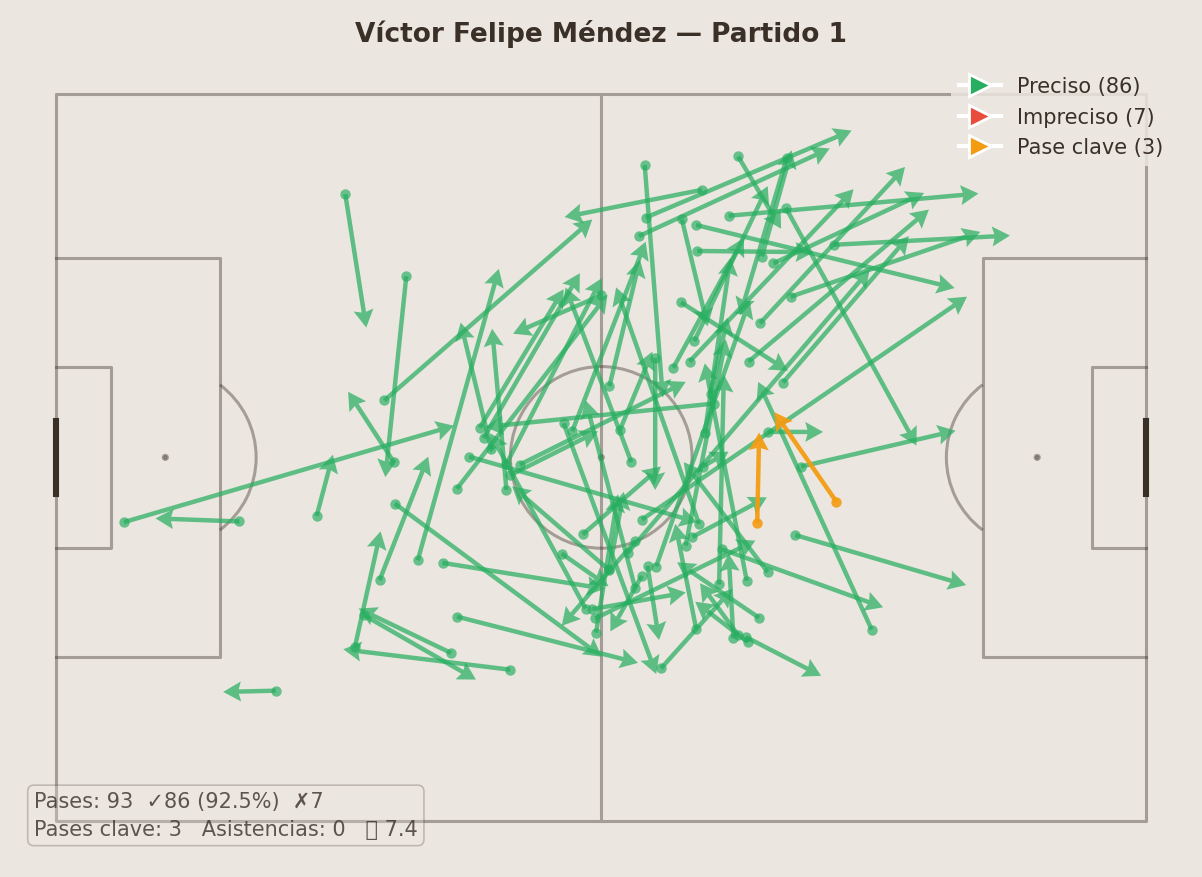

  [2] match 15352976  46 passes  inacc=3  kp=6  ast=1  -> Víctor_Felipe_Méndez_passes_match_2.png (145 KB)


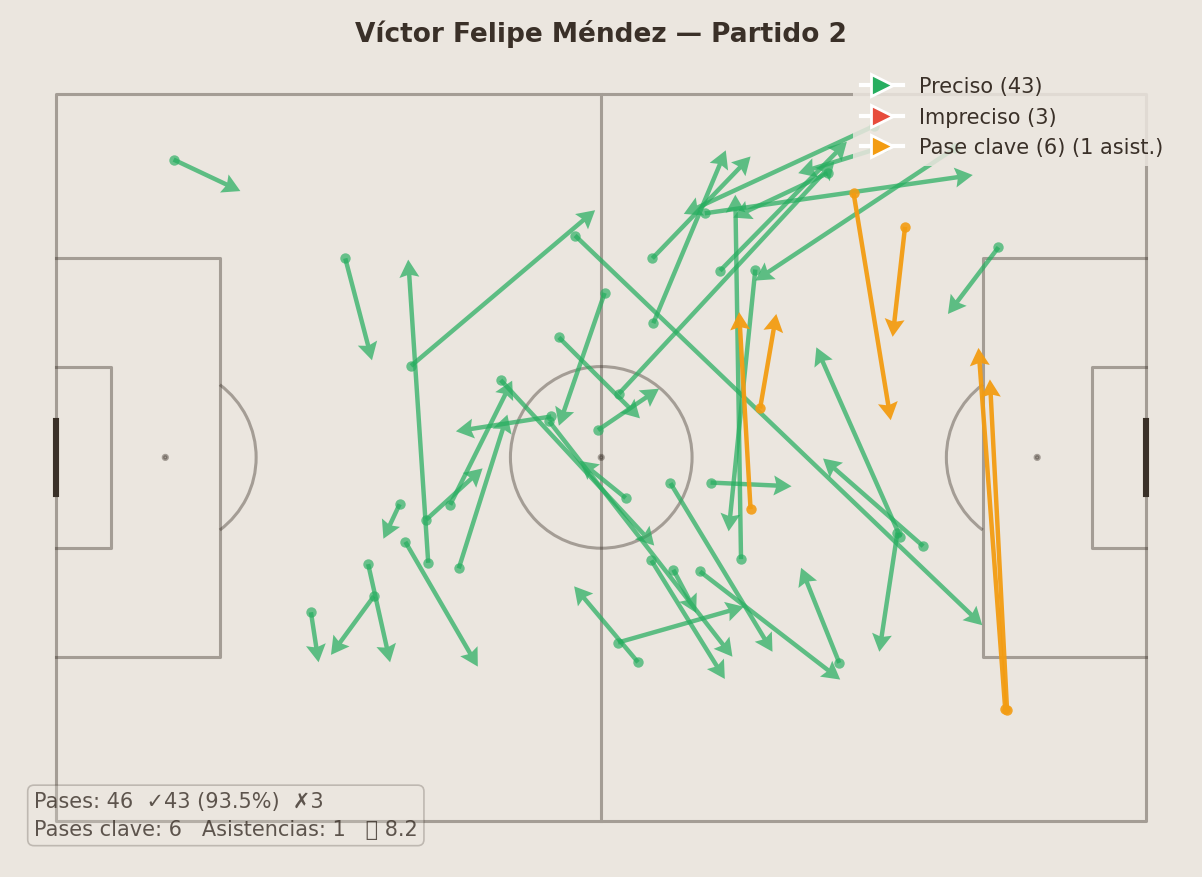

  [3] match 15352957  64 passes  inacc=5  kp=4  ast=0  -> Víctor_Felipe_Méndez_passes_match_3.png (170 KB)


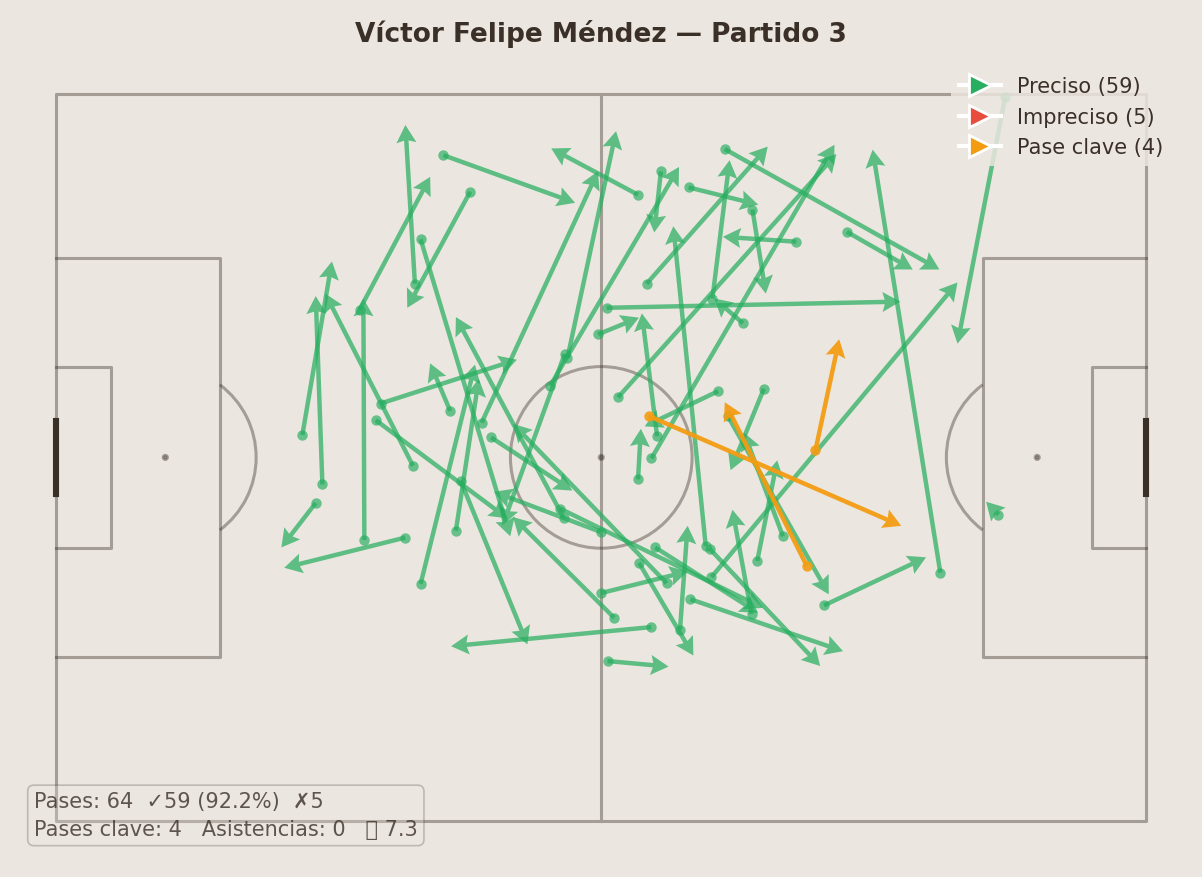

  [4] match 15352970  55 passes  inacc=7  kp=3  ast=0  -> Víctor_Felipe_Méndez_passes_match_4.png (140 KB)


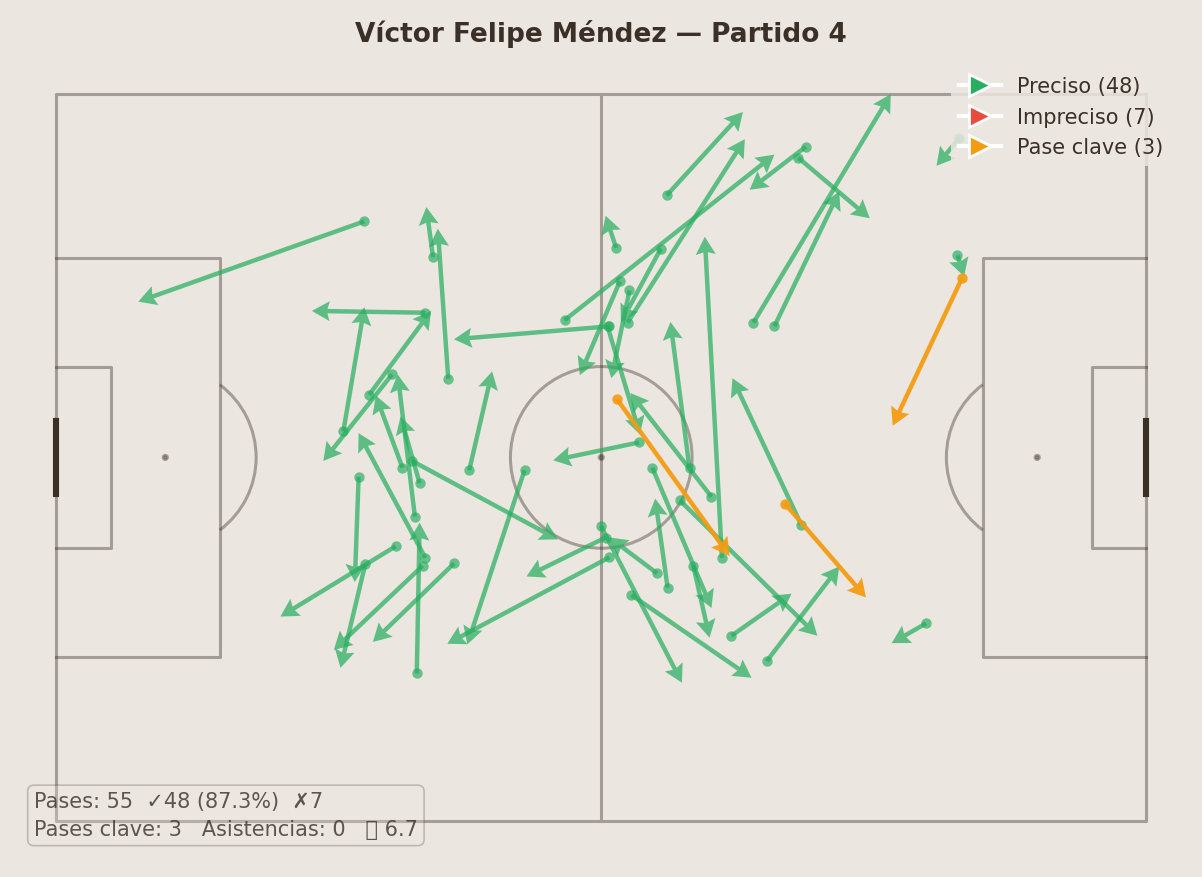


  [GLOBAL] 258 passes  acc=236 (91.5%)  inacc=22  kp=16  ast=1  -> Víctor_Felipe_Méndez_2026_passes_all.png (389 KB)


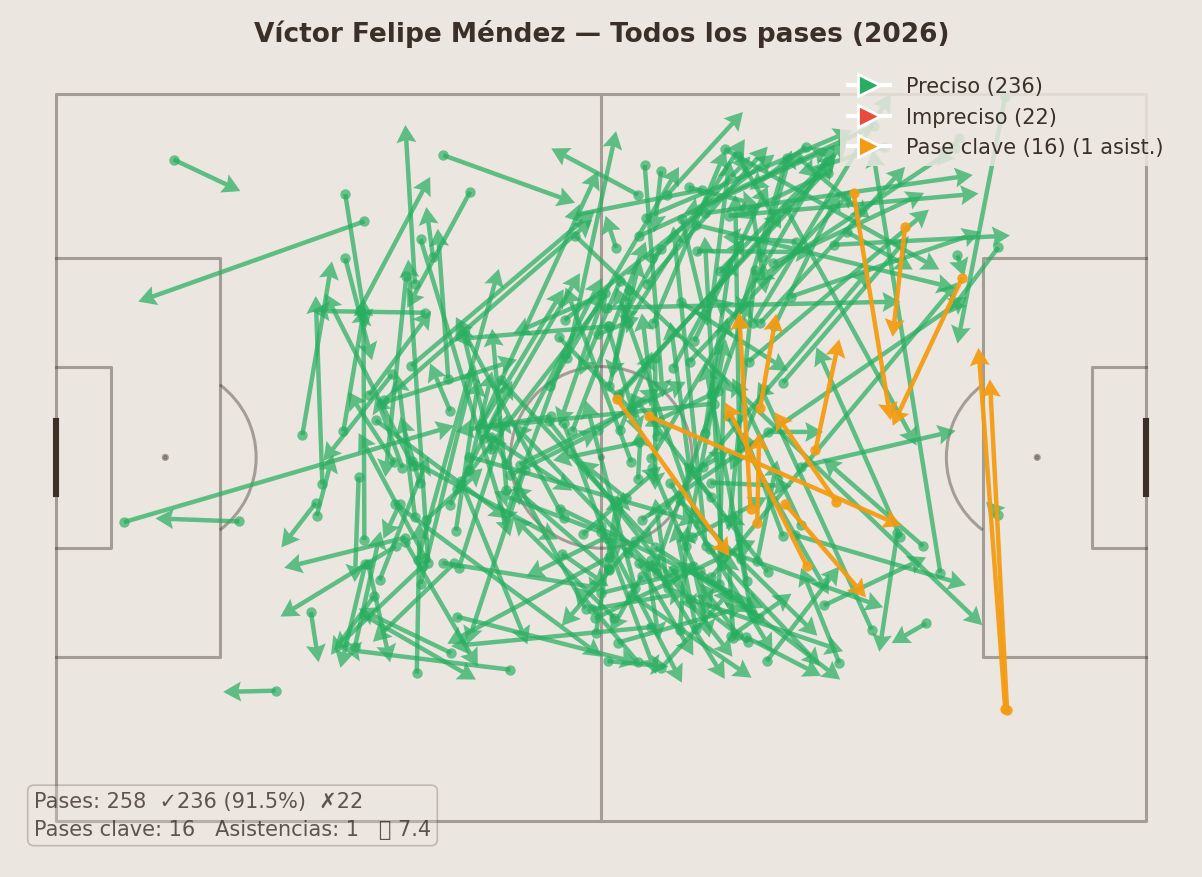


✅ Listo — PNGs en outputs/victor_felipe_mendez/


In [ ]:
"""
Cell 7 — Individual pass maps SofaScore-style (v3 — final)
- Green  = accurate pass (with coordinates)
- Gold   = key pass / assist (subset of accurate, with coordinates)
- Red    = inaccurate pass (real count from statistics, no exact coordinates)
- Cream background #EBE6DF — clean material for Photoshop editing
- One PNG per match + one global
- Loads match_stats from cache for real counts
"""
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import pandas as pd, json as _json

# ── Color palette ─────────────────────────────────────────────────────────────
BG_PM        = "#EBE6DF"
LINE_PM      = "#3A3028"
C_ACCURATE   = "#27AE60"
C_INACCURATE = "#E74C3C"
C_KEYPASS    = "#F39C12"

DPI_PM  = 200
W_PM, H_PM = 7.5, 5.2

# ── Load stats ────────────────────────────────────────────────────────────────
STATS_CACHE = OUTPUT_PATH / f"{SLUG}_match_stats.json"
if STATS_CACHE.exists():
    _ms_raw  = _json.loads(STATS_CACHE.read_text(encoding="utf-8"))
    match_stats = {int(k): v for k, v in _ms_raw.items()}
else:
    match_stats = {}
    print("WARNING: match_stats not found — run cell 5b first")

# ── Parse pass DataFrame (with coordinates) ───────────────────────────────────
df_pm = pd.DataFrame(all_passes)
for col, factor in [("x",105), ("y",68), ("end_x",105), ("end_y",68)]:
    df_pm[col] = pd.to_numeric(df_pm[col], errors="coerce") / 100 * factor
df_pm = df_pm.dropna(subset=["x","y","end_x","end_y"])
df_pm["accurate"] = df_pm["accurate"].astype(bool)
df_pm["keypass"]  = df_pm["keypass"].astype(bool)
df_pm["cat"] = "accurate"
df_pm.loc[~df_pm["accurate"], "cat"] = "inaccurate"
df_pm.loc[df_pm["keypass"],   "cat"] = "keypass"

print(f"Passes with coordinates: {len(df_pm)}")
if match_stats:
    tot_p   = sum(v["totalPass"]      for v in match_stats.values())
    tot_acc = sum(v["accuratePass"]   for v in match_stats.values())
    tot_in  = sum(v["inaccuratePass"] for v in match_stats.values())
    tot_a   = sum(v["goalAssist"]     for v in match_stats.values())
    print(f"Real stats: {tot_p} passes  acc={tot_acc}  inacc={tot_in}  ast={tot_a}")

from mplsoccer import Pitch
pitch = Pitch(
    pitch_type="statsbomb",
    pitch_color=BG_PM,
    line_color=LINE_PM,
    line_alpha=0.40,
    line_zorder=2,
    linewidth=1.1,
)

def draw_pass_map(df_match, ax, title="", st=None):
    """Draw pass arrows on pitch; add stats box with real counts."""
    pitch.draw(ax=ax)
    ax.set_facecolor(BG_PM)

    for cat, color, alpha, zo in [
        ("inaccurate", C_INACCURATE, 0.85, 3),
        ("accurate",   C_ACCURATE,   0.72, 3),
        ("keypass",    C_KEYPASS,     0.95, 4),
    ]:
        sub = df_match[df_match["cat"] == cat]
        if sub.empty:
            continue
        pitch.arrows(
            sub["x"], sub["y"], sub["end_x"], sub["end_y"],
            ax=ax, color=color, alpha=alpha,
            width=1.6, headwidth=4.5, headlength=4.0,
            headaxislength=3.5, zorder=zo,
        )
        ax.scatter(sub["x"], sub["y"], s=14, color=color,
                   alpha=alpha - 0.05, linewidths=0, zorder=zo)

    if title:
        ax.set_title(title, color=LINE_PM, fontsize=9.5,
                     fontweight="bold", pad=6, loc="center")

    # Stats box (bottom-left corner)
    if st:
        total   = st.get("totalPass", len(df_match))
        acc     = st.get("accuratePass", df_match["accurate"].sum())
        inacc   = st.get("inaccuratePass", 0)
        assists = st.get("goalAssist", 0)
        kp      = st.get("keyPass", df_match["keypass"].sum())
        rating  = st.get("rating", 0)
        acc_pct = round(acc / total * 100, 1) if total else 0
        stats_txt = (
            f"Passes: {total}  Acc: {acc} ({acc_pct}%)  Inacc: {inacc}\n"
            f"Key passes: {kp}   Assists: {assists}   Rating: {rating}"
        )
    else:
        n_acc  = int(df_match["accurate"].sum() + df_match["keypass"].sum())
        n_kp   = int(df_match["keypass"].sum())
        stats_txt = f"Acc: {n_acc}  Inacc: 0  KP: {n_kp}"

    ax.text(0.012, 0.022, stats_txt, transform=ax.transAxes,
            color=LINE_PM, fontsize=7.5, alpha=0.80,
            va="bottom", ha="left", linespacing=1.5,
            bbox=dict(boxstyle="round,pad=0.3", fc=BG_PM,
                      ec=LINE_PM, alpha=0.25, lw=0.6))

def make_legend(ax, st=None, df_match=None):
    n_acc   = st["accuratePass"]        if st else int(df_match["accurate"].sum())
    n_in    = st["inaccuratePass"]      if st else 0
    n_kp    = st["keyPass"]             if st else int(df_match["keypass"].sum())
    n_ast   = st.get("goalAssist", 0)   if st else 0

    ast_label = f" ({n_ast} assist)" if n_ast else ""
    handles = [
        Line2D([0],[0], marker=">", color="w", markerfacecolor=C_ACCURATE,
               markersize=8, label=f"Accurate ({n_acc})"),
        Line2D([0],[0], marker=">", color="w", markerfacecolor=C_INACCURATE,
               markersize=8, label=f"Inaccurate ({n_in})"),
        Line2D([0],[0], marker=">", color="w", markerfacecolor=C_KEYPASS,
               markersize=8, label=f"Key pass ({n_kp}){ast_label}"),
    ]
    ax.legend(
        handles=handles, loc="upper right", fontsize=7.5,
        frameon=True, framealpha=0.85, edgecolor="none",
        facecolor=BG_PM, labelcolor=LINE_PM,
    )

# ── 1. PNG per match ──────────────────────────────────────────────────────────
match_list = list(dict.fromkeys(df_pm["match_id"].tolist()))
print(f"\nGenerating {len(match_list)} maps + 1 global...\n")

for i, mid in enumerate(match_list, 1):
    df_m = df_pm[df_pm["match_id"] == mid]
    st   = match_stats.get(mid)

    fig, ax = plt.subplots(figsize=(W_PM, H_PM), dpi=DPI_PM, facecolor=BG_PM)
    fig.patch.set_facecolor(BG_PM)

    draw_pass_map(df_m, ax, title=f"Victor Felipe Mendez — Match {i}", st=st)
    make_legend(ax, st=st)

    out_pm = OUTPUT_PATH / f"{SLUG}_passes_match_{i}.png"
    fig.savefig(out_pm, dpi=DPI_PM, bbox_inches="tight", facecolor=BG_PM)
    sz = out_pm.stat().st_size / 1024
    total = st["totalPass"]      if st else "?"
    inacc = st["inaccuratePass"] if st else "?"
    kp    = st["keyPass"]        if st else "?"
    ast   = st["goalAssist"]     if st else "?"
    print(f"  [{i}] match {mid}  passes={total}  inacc={inacc}  kp={kp}  ast={ast}"
          f"  -> {out_pm.name} ({sz:.0f} KB)")
    plt.show()
    plt.close(fig)

# ── 2. Global PNG (all matches) ───────────────────────────────────────────────
if match_stats:
    st_all = {
        "totalPass":      sum(v["totalPass"]      for v in match_stats.values()),
        "accuratePass":   sum(v["accuratePass"]   for v in match_stats.values()),
        "inaccuratePass": sum(v["inaccuratePass"] for v in match_stats.values()),
        "goalAssist":     sum(v["goalAssist"]     for v in match_stats.values()),
        "keyPass":        sum(v["keyPass"]        for v in match_stats.values()),
        "rating":         round(sum(v["rating"] for v in match_stats.values()) / len(match_stats), 2),
    }
else:
    st_all = None

fig_all, ax_all = plt.subplots(figsize=(W_PM, H_PM), dpi=DPI_PM, facecolor=BG_PM)
fig_all.patch.set_facecolor(BG_PM)

draw_pass_map(df_pm, ax_all,
              title="Victor Felipe Mendez — All passes (2026)",
              st=st_all)
make_legend(ax_all, st=st_all)

out_all = OUTPUT_PATH / f"{SLUG}_{SEASON}_passes_all.png"
fig_all.savefig(out_all, dpi=DPI_PM, bbox_inches="tight", facecolor=BG_PM)
sz_all = out_all.stat().st_size / 1024
print(f"\n  [GLOBAL] passes={st_all['totalPass']}  "
      f"acc={st_all['accuratePass']} ({round(st_all['accuratePass']/st_all['totalPass']*100,1)}%)  "
      f"inacc={st_all['inaccuratePass']}  kp={st_all['keyPass']}  ast={st_all['goalAssist']}  "
      f"-> {out_all.name} ({sz_all:.0f} KB)")
plt.show()
plt.close(fig_all)

print("\nDone — PNGs saved in outputs/victor_felipe_mendez/")


Raw points: 321
            x       y  count
count  321.00  321.00  321.0
mean    57.73   56.22    1.1
std     18.73   24.39    0.3
min      7.00    0.00    1.0
25%     41.00   37.00    1.0
50%     61.00   60.00    1.0
75%     71.00   75.00    1.0
max     99.00  100.00    2.0

Expanded points (weighted): 352

Pitch coordinate ranges:
  px: 7.4 – 104.0  (expected 0–105)
  py: 0.0 – 68.0  (expected 0–68)


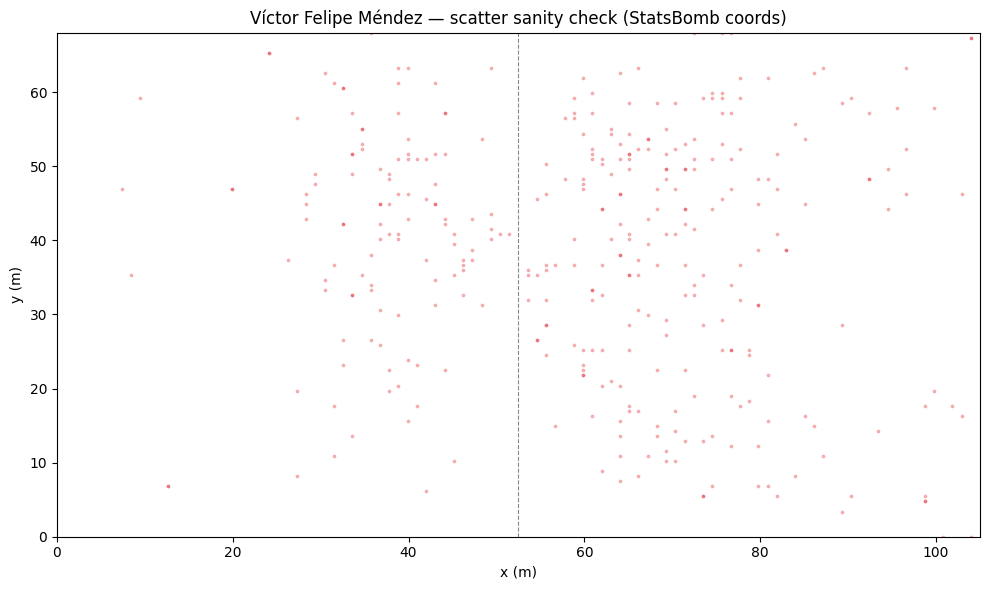

In [ ]:
"""
Cell 5 — Parse coordinates
SofaScore returns {x, y, count} on a 0-100 scale.
Convert to StatsBomb pitch coords (105 x 68 m) and expand by count
so the KDE correctly weights zones with higher activity.
"""
# Parse to DataFrame
df_raw = pd.DataFrame(points)           # columns: x, y, count
print(f"Raw points: {len(df_raw)}")
print(df_raw.describe().round(2))

# Repeat each point by its count (weighted KDE)
df_heat = df_raw.loc[df_raw.index.repeat(df_raw["count"].astype(int))].reset_index(drop=True)
print(f"\nExpanded points (weighted): {len(df_heat)}")

# Convert 0-100 -> StatsBomb pitch coords (105 x 68)
# SofaScore season heatmap: x = lengthwise (0=own goal, 100=opp goal), y = width
df_heat["px"] = df_heat["x"] / 100 * 105
df_heat["py"] = df_heat["y"] / 100 * 68

print(f"\nPitch coordinate ranges:")
print(f"  px: {df_heat['px'].min():.1f} - {df_heat['px'].max():.1f}  (expected 0-105)")
print(f"  py: {df_heat['py'].min():.1f} - {df_heat['py'].max():.1f}  (expected 0-68)")

# Quick scatter — sanity check
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_heat["px"], df_heat["py"], s=3, alpha=0.25, color="#E00D16")
ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_title(f"{PLAYER_NAME} — scatter sanity check (StatsBomb coords)")
ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")
ax.axvline(52.5, color="#888", lw=0.8, ls="--")
plt.tight_layout()
plt.show()


Saved -> Víctor_Felipe_Méndez_2026_heatmap.png  (233.4 KB)
Saved -> Víctor_Felipe_Méndez_2026_heatmap_transparent.png  (232.6 KB)


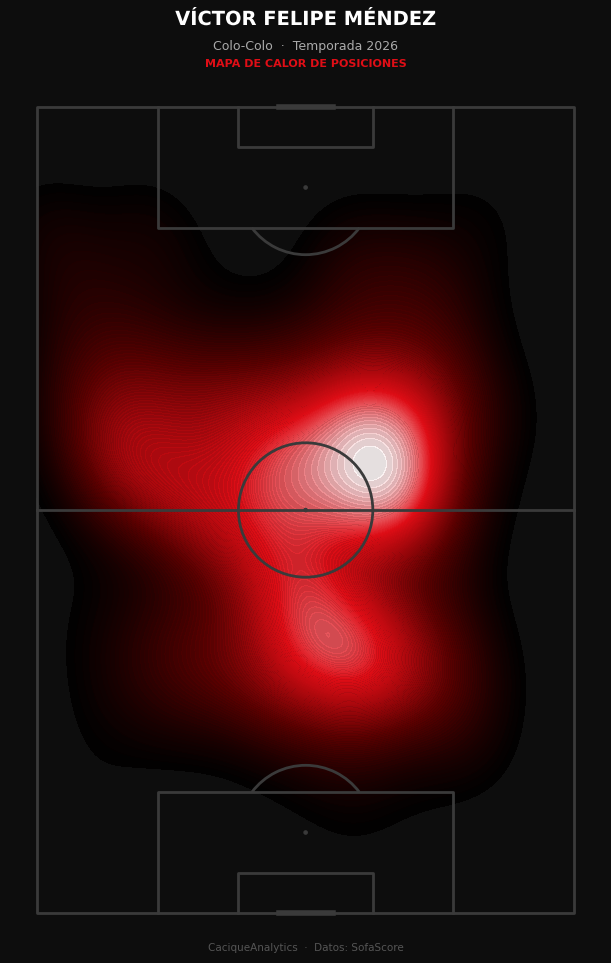

In [ ]:
"""
Cell 6 — Dark background heatmap (main post)
KDE on a dark vertical pitch, CaciqueAnalytics red colormap.
Exports dark PNG + transparent PNG.
"""
SLUG = PLAYER_NAME.replace(" ", "_")

CMAP_DARK = LinearSegmentedColormap.from_list(
    "cacique_dark",
    [(0, "#00000000"), (0.30, "#5C0000"), (0.65, "#E00D16"), (1.0, "#FFFFFF")],
    N=256,
)

def build_heatmap_dark(df: pd.DataFrame) -> None:
    pitch = VerticalPitch(
        pitch_type="statsbomb",
        pitch_color="#0D0D0D",
        line_color="#3A3A3A",
        half=False,
        line_zorder=2,
    )
    fig, ax = pitch.draw(figsize=(7, 10))
    fig.set_facecolor("#0D0D0D")

    pitch.kdeplot(
        df["px"], df["py"],
        ax=ax,
        cmap=CMAP_DARK,
        shade=True,
        levels=100,
        thresh=0.04,
        alpha=0.90,
        zorder=1,
    )

    fig.text(0.50, 0.965, PLAYER_NAME.upper(),
             color="#FFFFFF", fontsize=14, fontweight="black",
             ha="center", va="top", transform=fig.transFigure,
             path_effects=[pe.withStroke(linewidth=3, foreground="#0D0D0D")])
    fig.text(0.50, 0.935, f"{TEAM}  ·  Season {SEASON}",
             color="#AAAAAA", fontsize=9, ha="center", va="top", transform=fig.transFigure)
    fig.text(0.50, 0.916, "POSITION HEATMAP",
             color="#E00D16", fontsize=8, fontweight="bold",
             ha="center", va="top", transform=fig.transFigure)
    fig.text(0.50, 0.022, "CaciqueAnalytics  ·  Data: SofaScore",
             color="#555555", fontsize=7.5, ha="center", va="bottom", transform=fig.transFigure)

    plt.tight_layout(rect=[0, 0.02, 1, 0.91])

    for name, kw in [(f"{SLUG}_{SEASON}_heatmap.png", {}),
                     (f"{SLUG}_{SEASON}_heatmap_transparent.png", {"transparent": True})]:
        out = OUTPUT_PATH / name
        fig.savefig(out, dpi=200, bbox_inches="tight", **kw)
        print(f"Saved -> {out.name}  ({out.stat().st_size/1024:.1f} KB)")
    plt.show()

build_heatmap_dark(df_heat)


Saved -> Víctor_Felipe_Méndez_2026_heatmap_light.png  (230.2 KB)
Saved -> Víctor_Felipe_Méndez_2026_heatmap_light_transparent.png  (223.9 KB)


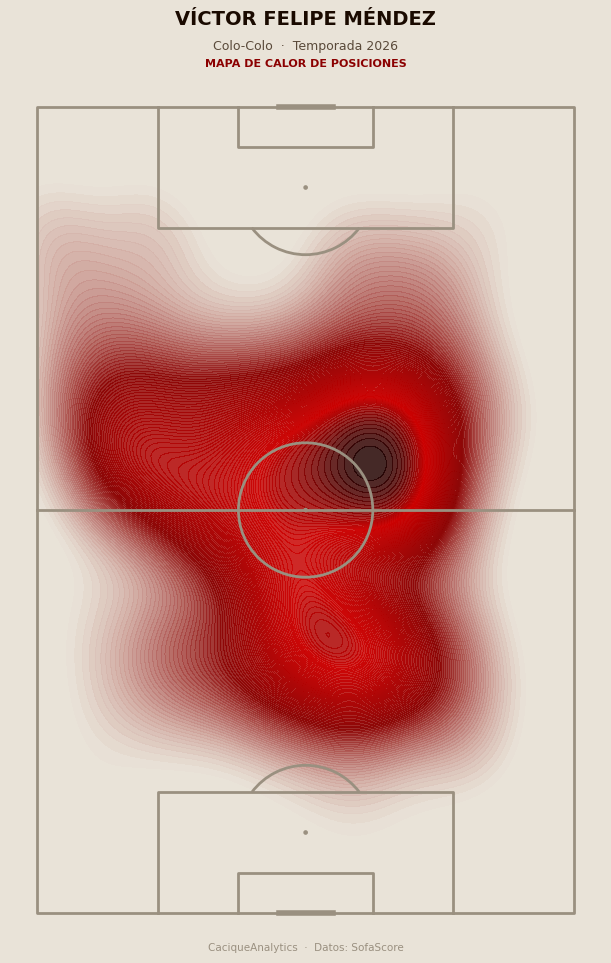

In [ ]:
"""
Cell 7 — Cream background heatmap (alternative variant)
Same #e9e3d8 palette used in the Jeyson Rojas post.
"""
CMAP_CREAM = LinearSegmentedColormap.from_list(
    "cacique_cream",
    [(0, "#e9e3d800"), (0.35, "#8B0000AA"), (0.70, "#CC0000"), (1.0, "#1A0000")],
    N=256,
)

def build_heatmap_light(df: pd.DataFrame) -> None:
    pitch = VerticalPitch(
        pitch_type="statsbomb",
        pitch_color="#e9e3d8",
        line_color="#9a9080",
        half=False,
        line_zorder=2,
    )
    fig, ax = pitch.draw(figsize=(7, 10))
    fig.set_facecolor("#e9e3d8")

    pitch.kdeplot(
        df["px"], df["py"],
        ax=ax,
        cmap=CMAP_CREAM,
        shade=True,
        levels=100,
        thresh=0.04,
        alpha=0.82,
        zorder=1,
    )

    fig.text(0.50, 0.965, PLAYER_NAME.upper(),
             color="#1A0A00", fontsize=14, fontweight="black",
             ha="center", va="top", transform=fig.transFigure)
    fig.text(0.50, 0.935, f"{TEAM}  ·  Season {SEASON}",
             color="#5A4A3A", fontsize=9, ha="center", va="top", transform=fig.transFigure)
    fig.text(0.50, 0.916, "POSITION HEATMAP",
             color="#8B0000", fontsize=8, fontweight="bold",
             ha="center", va="top", transform=fig.transFigure)
    fig.text(0.50, 0.022, "CaciqueAnalytics  ·  Data: SofaScore",
             color="#9a9080", fontsize=7.5, ha="center", va="bottom", transform=fig.transFigure)

    plt.tight_layout(rect=[0, 0.02, 1, 0.91])

    for name, kw in [(f"{SLUG}_{SEASON}_heatmap_light.png", {}),
                     (f"{SLUG}_{SEASON}_heatmap_light_transparent.png", {"transparent": True})]:
        out = OUTPUT_PATH / name
        fig.savefig(out, dpi=200, bbox_inches="tight", **kw)
        print(f"Saved -> {out.name}  ({out.stat().st_size/1024:.1f} KB)")
    plt.show()

build_heatmap_light(df_heat)


Points in attacking half: 235 / 352
Saved -> Víctor_Felipe_Méndez_2026_heatmap_half.png  (141.4 KB)
Saved -> Víctor_Felipe_Méndez_2026_heatmap_half_transparent.png  (142.8 KB)


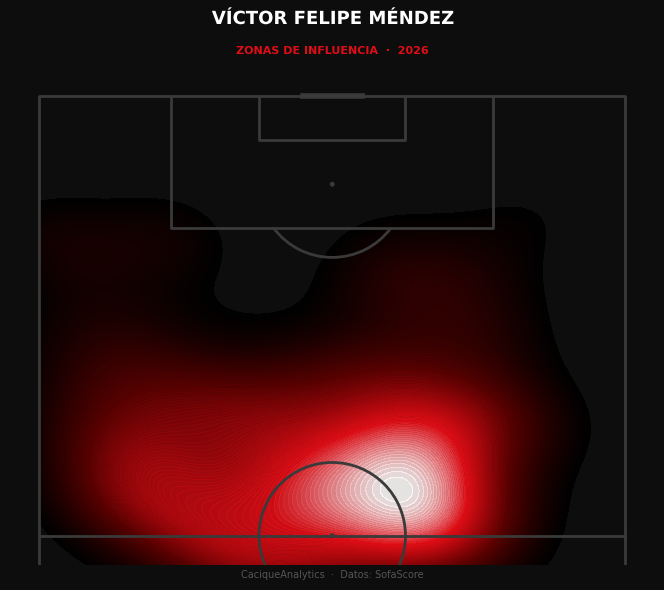

In [ ]:
"""
Cell 8 — Attacking half heatmap (half=True)
Shows only the attacking half to highlight offensive influence.
"""
df_att = df_heat[df_heat["px"] >= 52.5].copy()
print(f"Points in attacking half: {len(df_att)} / {len(df_heat)}")

def build_heatmap_half(df: pd.DataFrame) -> None:
    pitch = VerticalPitch(
        pitch_type="statsbomb",
        pitch_color="#0D0D0D",
        line_color="#3A3A3A",
        half=True,
        line_zorder=2,
    )
    fig, ax = pitch.draw(figsize=(7, 6))
    fig.set_facecolor("#0D0D0D")

    if len(df) < 10:
        ax.text(0.5, 0.5, "Not enough data points in attacking half",
                ha="center", va="center", color="white", transform=ax.transAxes)
    else:
        pitch.kdeplot(
            df["px"], df["py"],
            ax=ax,
            cmap=CMAP_DARK,
            shade=True,
            levels=100,
            thresh=0.04,
            alpha=0.90,
            zorder=1,
        )

    fig.text(0.50, 0.97, PLAYER_NAME.upper(),
             color="#FFFFFF", fontsize=13, fontweight="black",
             ha="center", va="top", transform=fig.transFigure,
             path_effects=[pe.withStroke(linewidth=3, foreground="#0D0D0D")])
    fig.text(0.50, 0.91, f"INFLUENCE ZONES  ·  {SEASON}",
             color="#E00D16", fontsize=8, fontweight="bold",
             ha="center", va="top", transform=fig.transFigure)
    fig.text(0.50, 0.02, "CaciqueAnalytics  ·  Data: SofaScore",
             color="#555555", fontsize=7, ha="center", va="bottom", transform=fig.transFigure)

    plt.tight_layout(rect=[0, 0.02, 1, 0.90])

    for name, kw in [(f"{SLUG}_{SEASON}_heatmap_half.png", {}),
                     (f"{SLUG}_{SEASON}_heatmap_half_transparent.png", {"transparent": True})]:
        out = OUTPUT_PATH / name
        fig.savefig(out, dpi=200, bbox_inches="tight", **kw)
        print(f"Saved -> {out.name}  ({out.stat().st_size/1024:.1f} KB)")
    plt.show()

build_heatmap_half(df_att)


In [ ]:
"""
Cell 9 — Zone breakdown
Divides the pitch into 6 zones (DEF/MID/ATT x LFT/CTR/RGT) using px/py.
Useful for verification and as copy data for the post.
"""
def zone_label(px, py):
    third  = "DEF" if px < 35  else ("MID" if px < 70 else "ATT")
    side   = "LFT" if py < 23  else ("CTR" if py < 45 else "RGT")
    return f"{third}-{side}"

df_heat["zone"] = df_heat.apply(lambda r: zone_label(r["px"], r["py"]), axis=1)

zone_order = [
    "ATT-LFT", "ATT-CTR", "ATT-RGT",
    "MID-LFT", "MID-CTR", "MID-RGT",
    "DEF-LFT", "DEF-CTR", "DEF-RGT",
]
counts = df_heat["zone"].value_counts().reindex(zone_order, fill_value=0)
pcts   = (counts / counts.sum() * 100).round(1)

print(f"Zone distribution — {PLAYER_NAME} {SEASON}")
print(f"\n{'Zone':<12} {'Points':>8} {'%':>7}")
print("-" * 30)
for z in zone_order:
    bar = "#" * int(pcts[z] / 2)
    print(f"{z:<12} {counts[z]:>8} {pcts[z]:>6.1f}%  {bar}")

top_zone = pcts.idxmax()
print(f"\n-> Most active zone: {top_zone} ({pcts[top_zone]:.1f}%)")


Zone distribution — Víctor Felipe Méndez 2026

Zone           Points       %
------------------------------
ATT-LFT            37   10.5%  █████
ATT-CTR            31    8.8%  ████
ATT-RGT            50   14.2%  ███████
MID-LFT            31    8.8%  ████
MID-CTR            89   25.3%  ████████████
MID-RGT            71   20.2%  ██████████
DEF-LFT             7    2.0%  █
DEF-CTR            14    4.0%  ██
DEF-RGT            22    6.2%  ███

-> Most active zone: MID-CTR (25.3%)


Saved -> Víctor_Felipe_Méndez_2026_heatmap_hex.png  (158.2 KB)
Saved -> Víctor_Felipe_Méndez_2026_heatmap_hex_transparent.png  (185.7 KB)


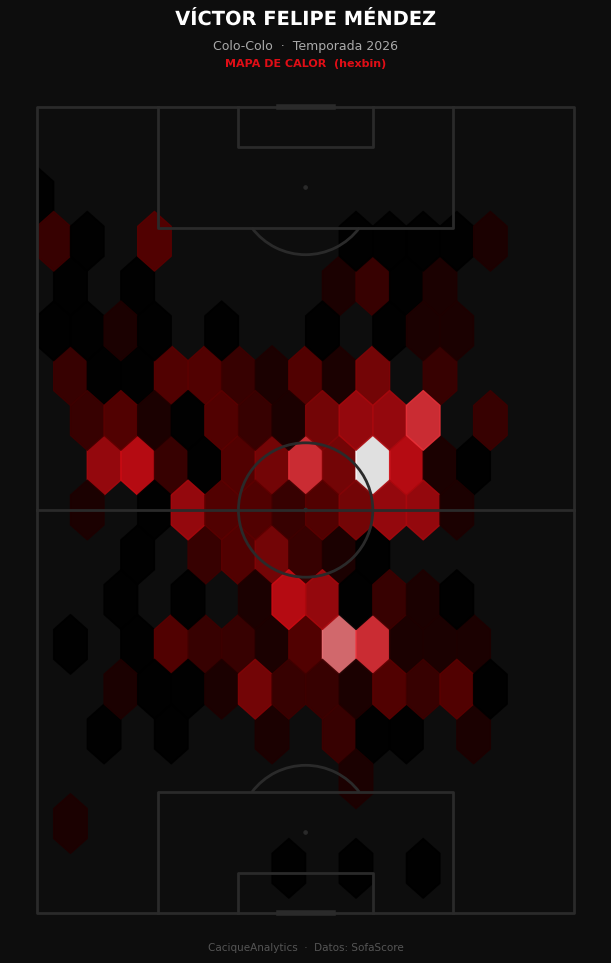

In [ ]:
"""
Cell 10 — Hexbin heatmap (textured variant)
hexbin gives a more stylized look and better visualizes point density.
Exports dark and transparent versions.
"""
def build_heatmap_hex(df: pd.DataFrame) -> None:
    pitch = VerticalPitch(
        pitch_type="statsbomb",
        pitch_color="#0D0D0D",
        line_color="#2A2A2A",
        half=False,
        line_zorder=2,
    )
    fig, ax = pitch.draw(figsize=(7, 10))
    fig.set_facecolor("#0D0D0D")

    pitch.hexbin(
        df["px"], df["py"],
        ax=ax,
        gridsize=16,
        cmap=CMAP_DARK,
        alpha=0.88,
        zorder=1,
    )

    fig.text(0.50, 0.965, PLAYER_NAME.upper(),
             color="#FFFFFF", fontsize=14, fontweight="black",
             ha="center", va="top", transform=fig.transFigure,
             path_effects=[pe.withStroke(linewidth=3, foreground="#0D0D0D")])
    fig.text(0.50, 0.935, f"{TEAM}  ·  Season {SEASON}",
             color="#AAAAAA", fontsize=9, ha="center", va="top", transform=fig.transFigure)
    fig.text(0.50, 0.916, "HEATMAP  (hexbin)",
             color="#E00D16", fontsize=8, fontweight="bold",
             ha="center", va="top", transform=fig.transFigure)
    fig.text(0.50, 0.022, "CaciqueAnalytics  ·  Data: SofaScore",
             color="#555555", fontsize=7.5, ha="center", va="bottom", transform=fig.transFigure)

    plt.tight_layout(rect=[0, 0.02, 1, 0.91])

    for name, kw in [(f"{SLUG}_{SEASON}_heatmap_hex.png", {}),
                     (f"{SLUG}_{SEASON}_heatmap_hex_transparent.png", {"transparent": True})]:
        out = OUTPUT_PATH / name
        fig.savefig(out, dpi=200, bbox_inches="tight", **kw)
        print(f"Saved -> {out.name}  ({out.stat().st_size/1024:.1f} KB)")
    plt.show()

build_heatmap_hex(df_heat)


In [ ]:
"""
Cell 11 — Summary of generated files
Lists all exported PNGs and JSON files with their sizes.
"""
generated = sorted(OUTPUT_PATH.glob(f"{SLUG}*"))

print(f"Generated files — {PLAYER_NAME} {SEASON}:")
print(f"Output folder: {OUTPUT_PATH.resolve()}\n")
for f in generated:
    size_kb = f.stat().st_size / 1024
    print(f"  {f.name:<70}  {size_kb:>7.1f} KB")

if not generated:
    print("  (no files — run the visualization cells first)")


Archivos generados — Víctor Felipe Méndez 2026:
Carpeta: C:\Users\PC\Projects\CaciqueAnalytics\outputs\victor_felipe_mendez

  Víctor_Felipe_Méndez_2025_vs_Víctor_Felipe_Méndez_2026.png                249.4 KB
  Víctor_Felipe_Méndez_2025_vs_Víctor_Felipe_Méndez_2026_minimal.png        214.5 KB
  Víctor_Felipe_Méndez_2025_vs_Víctor_Felipe_Méndez_2026_minimal_transparent.png    207.6 KB
  Víctor_Felipe_Méndez_2025_vs_Víctor_Felipe_Méndez_2026_transparent.png    234.1 KB
  Víctor_Felipe_Méndez_2026_bars.png                                         71.0 KB
  Víctor_Felipe_Méndez_2026_bars_transparent.png                             53.8 KB
  Víctor_Felipe_Méndez_2026_heatmap.png                                     233.4 KB
  Víctor_Felipe_Méndez_2026_heatmap_half.png                                141.4 KB
  Víctor_Felipe_Méndez_2026_heatmap_half_transparent.png                    142.8 KB
  Víctor_Felipe_Méndez_2026_heatmap_hex.png                                 158.2 KB
  Víctor_Felipe_M

In [ ]:
"""
Cell 12 — Quick reload from cache (no browser needed)
To rebuild the heatmap DataFrames without re-running cells 2-4,
just run this cell — it loads the saved raw JSON and rebuilds the DataFrames.
"""
raw_path = OUTPUT_PATH / f"{SLUG}_heatmap_raw.json"
if raw_path.exists():
    raw  = json.loads(raw_path.read_text(encoding="utf-8"))
    pts  = raw.get("points", [])
    df_raw  = pd.DataFrame(pts)
    df_heat = df_raw.loc[df_raw.index.repeat(df_raw["count"].astype(int))].reset_index(drop=True)
    df_heat["px"] = df_heat["x"] / 100 * 105
    df_heat["py"] = df_heat["y"] / 100 * 68
    df_att  = df_heat[df_heat["px"] >= 52.5].copy()
    print(f"Loaded from cache: {len(df_heat)} weighted points")
    print(f"  Attacking half : {len(df_att)} points")
else:
    print("Cache not found — run cells 4-5 first.")


Loaded from cache: 352 weighted points
  Attacking half : 235 points


Accurate passes:   264
Inaccurate passes: 19 (estimated from screenshots)
Total:            283

Generating PNGs...

  [1] vs O'Higgins: acc=94  inacc=7(est)  kp=2  -> Víctor_Felipe_Méndez_passes_match_1.png (220 KB)


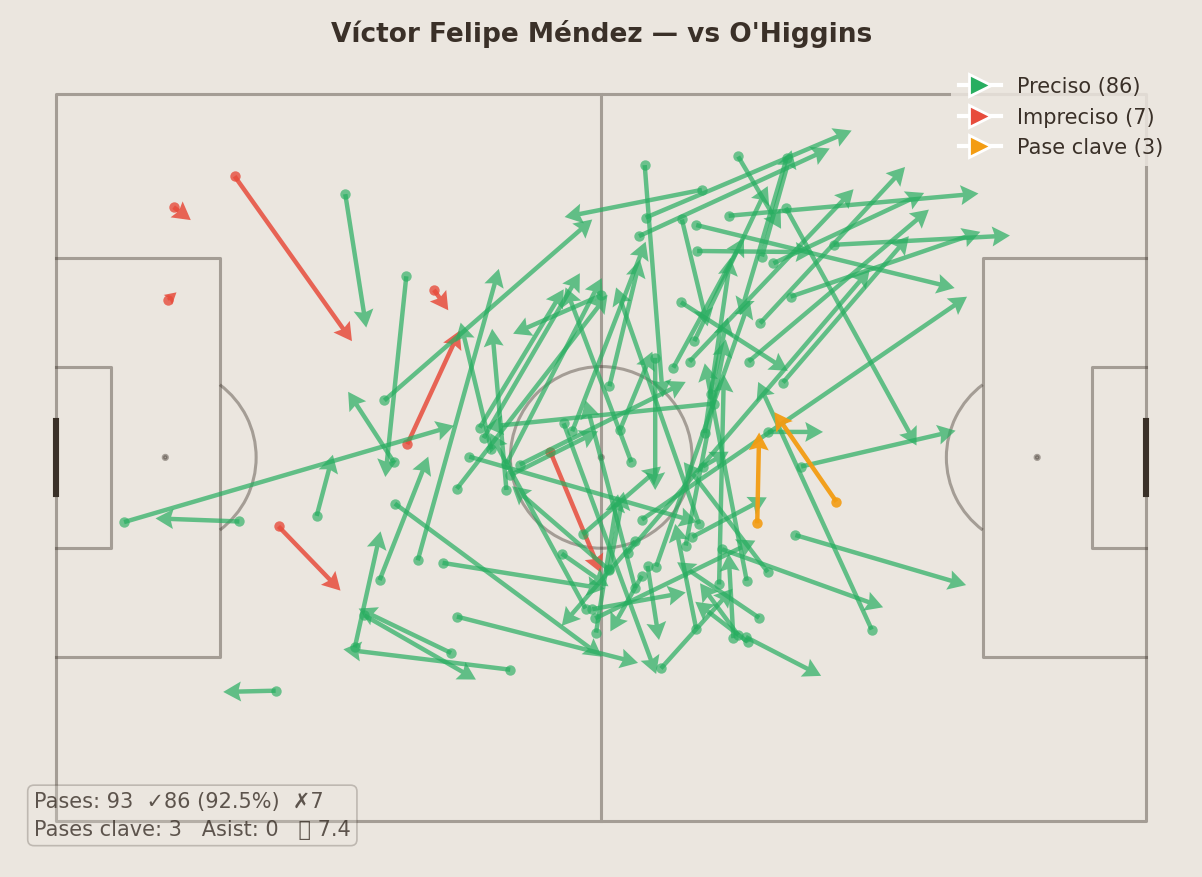

  [2] vs La Calera: acc=49  inacc=5(est)  kp=6  -> Víctor_Felipe_Méndez_passes_match_2.png (153 KB)


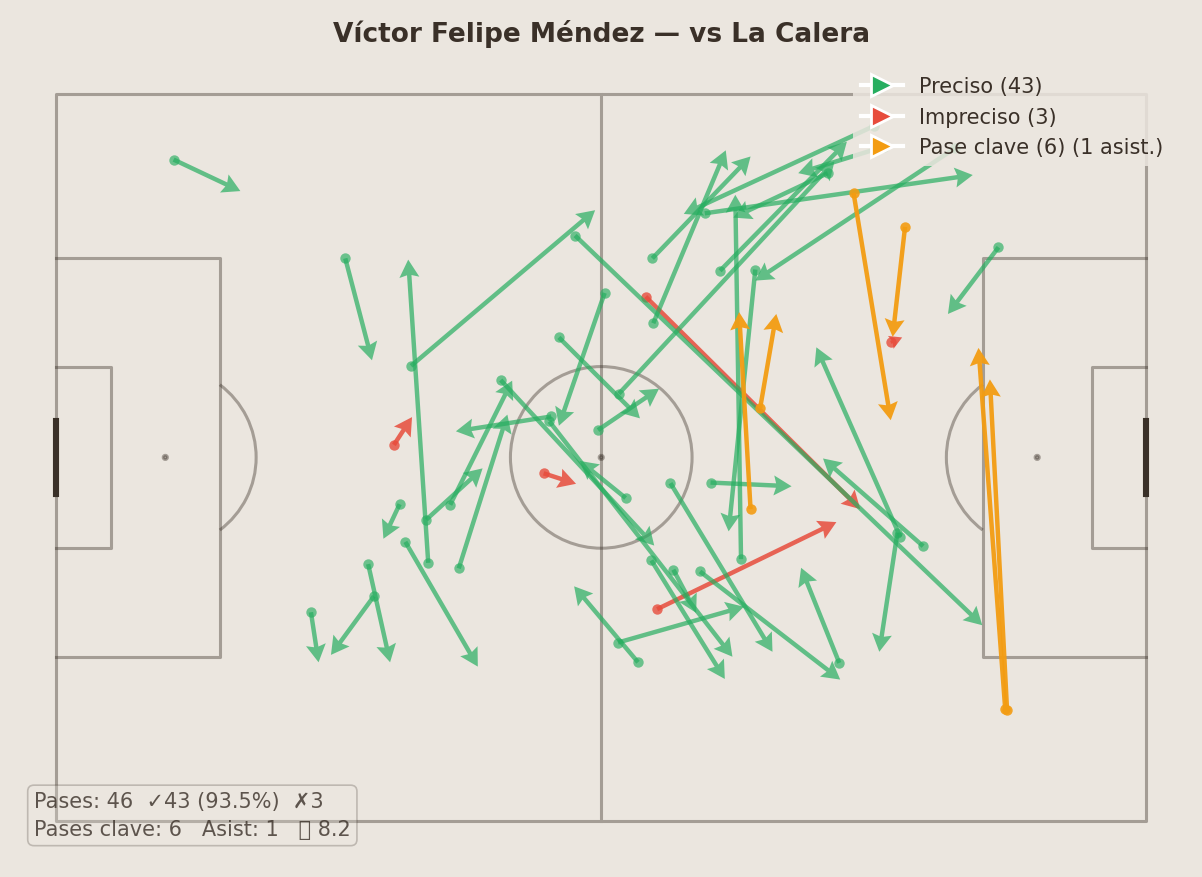

  [3] vs Everton: acc=66  inacc=3(est)  kp=3  -> Víctor_Felipe_Méndez_passes_match_3.png (173 KB)


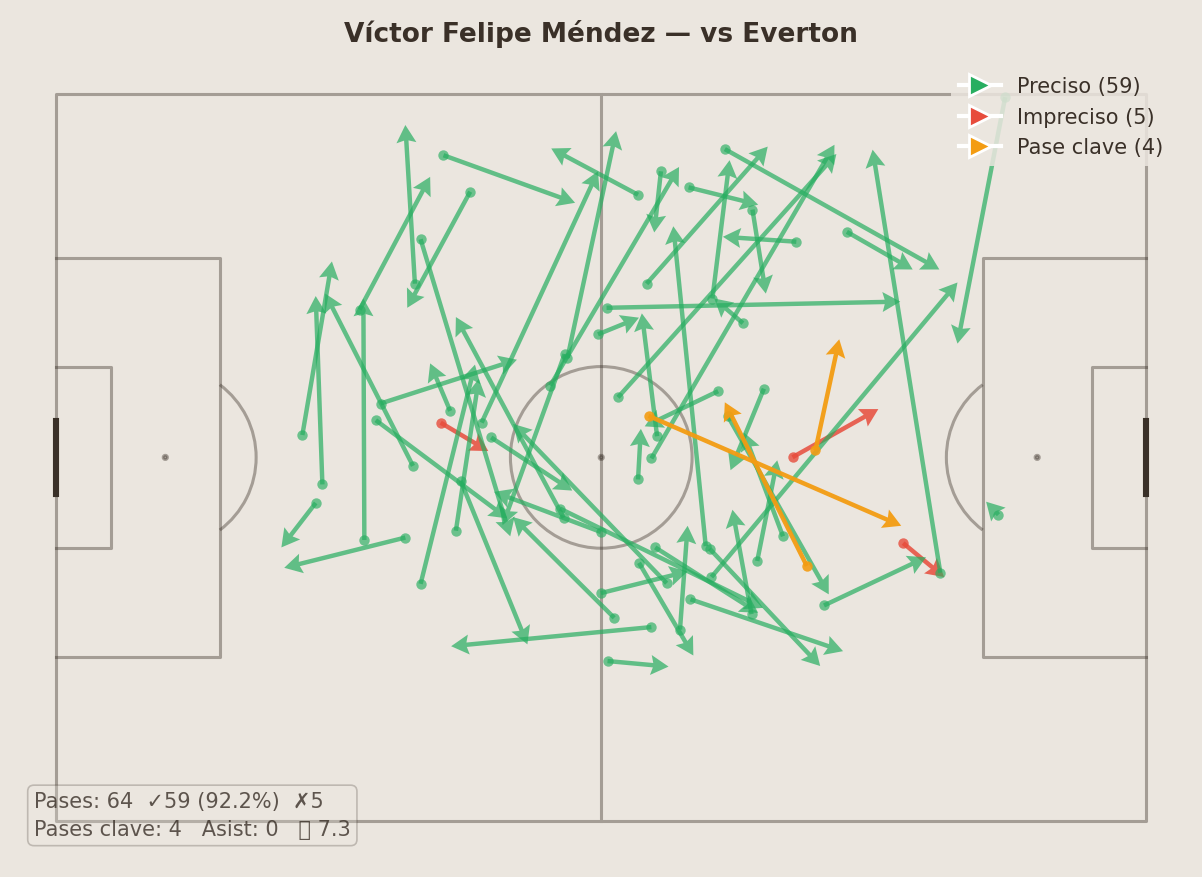

  [4] vs Limache: acc=55  inacc=4(est)  kp=3  -> Víctor_Felipe_Méndez_passes_match_4.png (148 KB)


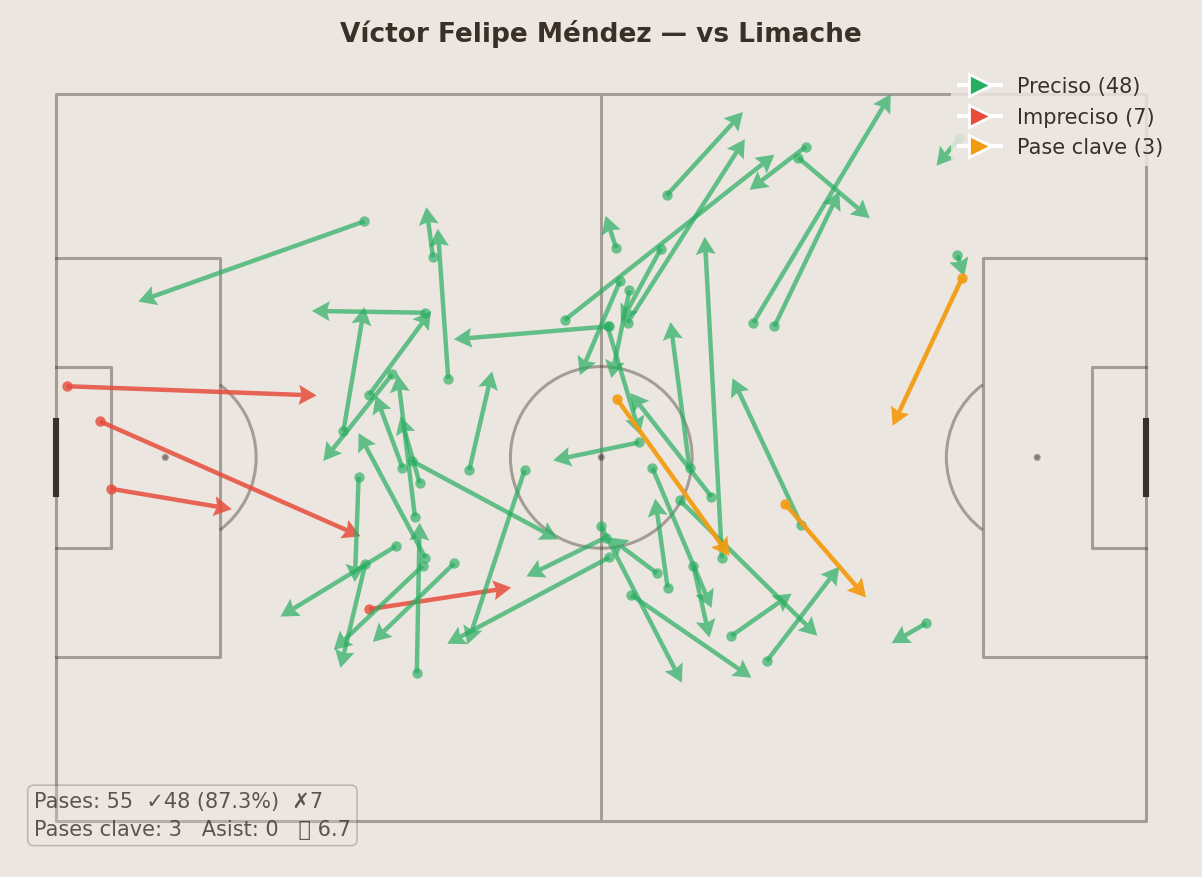


  [GLOBAL] acc=236  inacc=22  kp=16  ast=1  -> Víctor_Felipe_Méndez_2026_passes_all.png (418 KB)


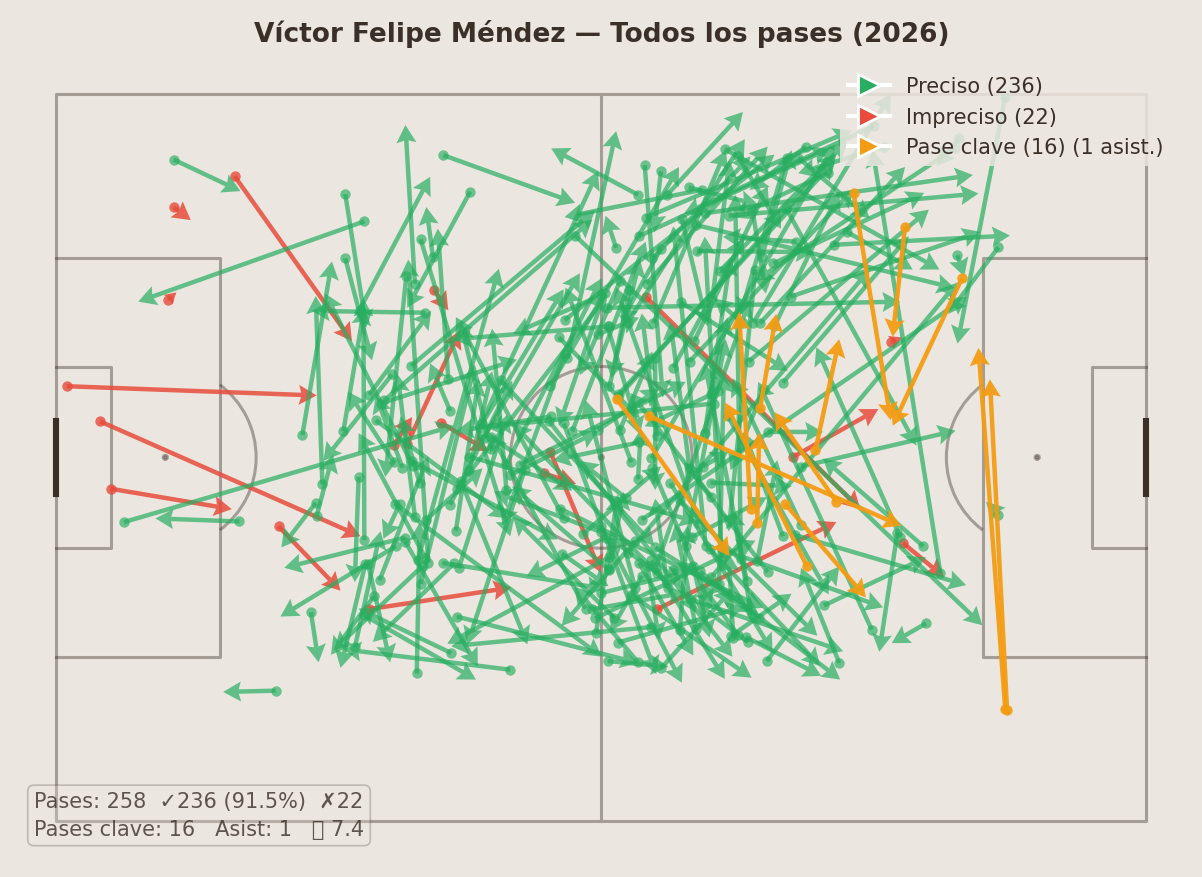


✅ Todos los PNGs generados en outputs/victor_felipe_mendez/


In [ ]:
"""
Cell FINAL — Complete pass maps (accurate + estimated inaccurate)
- Loads accurate passes from cache  (rating-breakdown)
- Loads estimated inaccurate passes (detected from screenshots via color analysis)
- Combines both and generates PNG per match + global
- Green = accurate  |  Gold = key pass  |  Red = inaccurate (estimated)
"""
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd, json as _json, numpy as np
from pathlib import Path
from mplsoccer import Pitch

# ── Paths ──────────────────────────────────────────────────────────────────────
OUTPUT_PATH  = Path(r"c:\Users\PC\Projects\CaciqueAnalytics\outputs\victor_felipe_mendez")
ASSETS_PATH  = Path(r"c:\Users\PC\Projects\CaciqueAnalytics\assets")
PASS_CACHE   = OUTPUT_PATH / "Víctor_Felipe_Méndez_passes_raw.json"
STATS_CACHE  = OUTPUT_PATH / "Víctor_Felipe_Méndez_match_stats.json"
INACC_CACHE  = OUTPUT_PATH / "mendez_inaccurate_estimated.json"

# Match IDs in order: O'Higgins, Everton, La Calera, Limache
MATCH_IDS    = [15352965, 15352976, 15352957, 15352970]
MATCH_LABELS = {
    15352965: "vs O'Higgins",
    15352976: "vs Everton",
    15352957: "vs La Calera",
    15352970: "vs Limache",
}

# ── Load data ──────────────────────────────────────────────────────────────────
all_passes_raw = _json.loads(PASS_CACHE.read_text(encoding="utf-8"))
match_stats    = {int(k): v for k, v in _json.loads(STATS_CACHE.read_text(encoding="utf-8")).items()}
inacc_raw      = {int(k): v for k, v in _json.loads(INACC_CACHE.read_text(encoding="utf-8")).items()}

# ── Convert accurate passes to DataFrame (0-100 -> StatsBomb 105x68) ──────────
df_acc = pd.DataFrame(all_passes_raw)
for col, factor in [("x",105), ("y",68), ("end_x",105), ("end_y",68)]:
    df_acc[col] = pd.to_numeric(df_acc[col], errors="coerce") / 100 * factor
df_acc = df_acc.dropna(subset=["x","y","end_x","end_y"])
df_acc["accurate"] = True
df_acc["keypass"]  = df_acc["keypass"].astype(bool)

# ── Convert estimated inaccurate passes (0-100 -> StatsBomb) + assign match_id ─
inacc_rows = []
match_num_to_id = {i+1: mid for i, mid in enumerate(MATCH_IDS)}
for match_num, passes in inacc_raw.items():
    mid = match_num_to_id.get(int(match_num))
    for p in passes:
        inacc_rows.append({
            "match_id": mid,
            "x":       p["x"]     / 100 * 105,
            "y":       p["y"]     / 100 * 68,
            "end_x":   p["end_x"] / 100 * 105,
            "end_y":   p["end_y"] / 100 * 68,
            "accurate": False,
            "keypass":  False,
        })

df_inacc = pd.DataFrame(inacc_rows)

# ── Combine ────────────────────────────────────────────────────────────────────
df_all = pd.concat([df_acc, df_inacc], ignore_index=True)
df_all["cat"] = "accurate"
df_all.loc[~df_all["accurate"], "cat"] = "inaccurate"
df_all.loc[df_all["keypass"],   "cat"] = "keypass"

print(f"Accurate passes:   {len(df_acc)}")
print(f"Inaccurate passes: {len(df_inacc)} (estimated from screenshots)")
print(f"Total:             {len(df_all)}")

# ── Color palette ──────────────────────────────────────────────────────────────
BG_PM        = "#EBE6DF"
LINE_PM      = "#3A3028"
C_ACCURATE   = "#27AE60"
C_INACCURATE = "#E74C3C"
C_KEYPASS    = "#F39C12"
DPI_PM       = 200
W_PM, H_PM   = 7.5, 5.2

pitch = Pitch(
    pitch_type="statsbomb", pitch_color=BG_PM,
    line_color=LINE_PM, line_alpha=0.40,
    line_zorder=2, linewidth=1.1,
)

def draw_pass_map(df_match, ax, title="", st=None):
    pitch.draw(ax=ax)
    ax.set_facecolor(BG_PM)
    for cat, color, alpha, zo in [
        ("inaccurate", C_INACCURATE, 0.85, 3),
        ("accurate",   C_ACCURATE,   0.70, 3),
        ("keypass",    C_KEYPASS,     0.95, 4),
    ]:
        sub = df_match[df_match["cat"] == cat]
        if sub.empty:
            continue
        pitch.arrows(sub["x"], sub["y"], sub["end_x"], sub["end_y"],
                     ax=ax, color=color, alpha=alpha,
                     width=1.6, headwidth=4.5, headlength=4.0,
                     headaxislength=3.5, zorder=zo)
        ax.scatter(sub["x"], sub["y"], s=14, color=color,
                   alpha=alpha - 0.05, linewidths=0, zorder=zo)

    if title:
        ax.set_title(title, color=LINE_PM, fontsize=9.5,
                     fontweight="bold", pad=6, loc="center")

    if st:
        total = st.get("totalPass", len(df_match))
        acc   = st.get("accuratePass", 0)
        inacc = st.get("inaccuratePass", 0)
        ast   = st.get("goalAssist", 0)
        kp    = st.get("keyPass", 0)
        rat   = st.get("rating", 0)
        pct   = round(acc / total * 100, 1) if total else 0
        txt = (f"Passes: {total}  Acc: {acc} ({pct}%)  Inacc: {inacc}\n"
               f"Key passes: {kp}   Assists: {ast}   Rating: {rat}")
    else:
        n_acc = int((df_match["cat"] == "accurate").sum() + (df_match["cat"] == "keypass").sum())
        n_in  = int((df_match["cat"] == "inaccurate").sum())
        n_kp  = int((df_match["cat"] == "keypass").sum())
        pct   = round(n_acc / (n_acc + n_in) * 100, 1) if (n_acc + n_in) else 0
        txt   = f"Passes: {n_acc+n_in}  Acc: {n_acc} ({pct}%)  Inacc: {n_in}  KP: {n_kp}"
    ax.text(0.012, 0.022, txt, transform=ax.transAxes,
            color=LINE_PM, fontsize=7.5, alpha=0.80,
            va="bottom", ha="left", linespacing=1.5,
            bbox=dict(boxstyle="round,pad=0.3", fc=BG_PM,
                      ec=LINE_PM, alpha=0.25, lw=0.6))

def make_legend(ax, st=None, df_match=None):
    n_acc  = st["accuratePass"]      if st else int((df_match["cat"]=="accurate").sum() + (df_match["cat"]=="keypass").sum())
    n_in   = st["inaccuratePass"]    if st else int((df_match["cat"]=="inaccurate").sum())
    n_kp   = st["keyPass"]           if st else int((df_match["cat"]=="keypass").sum())
    n_ast  = st.get("goalAssist",0)  if st else 0
    ast_lbl = f" ({n_ast} assist)" if n_ast else ""
    ax.legend(
        handles=[
            Line2D([0],[0], marker=">", color="w", markerfacecolor=C_ACCURATE,
                   markersize=8, label=f"Accurate ({n_acc})"),
            Line2D([0],[0], marker=">", color="w", markerfacecolor=C_INACCURATE,
                   markersize=8, label=f"Inaccurate ({n_in})"),
            Line2D([0],[0], marker=">", color="w", markerfacecolor=C_KEYPASS,
                   markersize=8, label=f"Key pass ({n_kp}){ast_lbl}"),
        ],
        loc="upper right", fontsize=7.5, frameon=True, framealpha=0.85,
        edgecolor="none", facecolor=BG_PM, labelcolor=LINE_PM,
    )

# ── 1. PNG per match ───────────────────────────────────────────────────────────
print("\nGenerating PNGs...\n")
for i, mid in enumerate(MATCH_IDS, 1):
    df_m = df_all[df_all["match_id"] == mid]
    st   = match_stats.get(mid)
    lbl  = MATCH_LABELS.get(mid, f"Match {i}")
    fig, ax = plt.subplots(figsize=(W_PM, H_PM), dpi=DPI_PM, facecolor=BG_PM)
    fig.patch.set_facecolor(BG_PM)
    draw_pass_map(df_m, ax, title=f"Victor Felipe Mendez — {lbl}", st=st)
    make_legend(ax, st=st)
    out = OUTPUT_PATH / f"Víctor_Felipe_Méndez_passes_match_{i}.png"
    fig.savefig(out, dpi=DPI_PM, bbox_inches="tight", facecolor=BG_PM)
    sz = out.stat().st_size / 1024
    n_in_m = len(df_inacc[df_inacc["match_id"] == mid])
    print(f"  [{i}] {lbl}: acc={int((df_m['cat']=='accurate').sum()+(df_m['cat']=='keypass').sum())}  "
          f"inacc={n_in_m}(est)  kp={int((df_m['cat']=='keypass').sum())}  -> {out.name} ({sz:.0f} KB)")
    plt.show()
    plt.close(fig)

# ── 2. Global PNG ──────────────────────────────────────────────────────────────
st_all = {
    "totalPass":      sum(v["totalPass"]      for v in match_stats.values()),
    "accuratePass":   sum(v["accuratePass"]   for v in match_stats.values()),
    "inaccuratePass": sum(v["inaccuratePass"] for v in match_stats.values()),
    "goalAssist":     sum(v["goalAssist"]     for v in match_stats.values()),
    "keyPass":        sum(v["keyPass"]        for v in match_stats.values()),
    "rating":         round(sum(v["rating"]   for v in match_stats.values()) / len(match_stats), 2),
}
fig_all, ax_all = plt.subplots(figsize=(W_PM, H_PM), dpi=DPI_PM, facecolor=BG_PM)
fig_all.patch.set_facecolor(BG_PM)
draw_pass_map(df_all, ax_all,
              title="Victor Felipe Mendez — All passes (2026)", st=st_all)
make_legend(ax_all, st=st_all)
out_all = OUTPUT_PATH / "Víctor_Felipe_Méndez_2026_passes_all.png"
fig_all.savefig(out_all, dpi=DPI_PM, bbox_inches="tight", facecolor=BG_PM)
sz_all = out_all.stat().st_size / 1024
print(f"\n  [GLOBAL] passes={st_all['totalPass']}  "
      f"acc={st_all['accuratePass']} ({round(st_all['accuratePass']/st_all['totalPass']*100,1)}%)  "
      f"inacc={st_all['inaccuratePass']}  kp={st_all['keyPass']}  ast={st_all['goalAssist']}  "
      f"-> {out_all.name} ({sz_all:.0f} KB)")
plt.show()
plt.close(fig_all)
print("\nAll PNGs saved to outputs/victor_felipe_mendez/")


In [29]:
"""
Cell — Key Passes & Assists — Build df_passes
==============================================
Reads from enriched cache (mendez_passes_enriched.json).
Falls back to original cache if enriched one doesn't exist yet
(run the re-scrape cell above first).

Columns in df_passes:
  type = "Assist"    → sky blue (#00BFFF)
  type = "Key Pass"  → gold    (#DAA520)
"""
import json
import pandas as pd
from pathlib import Path

_OUTPUT     = Path(r"c:\Users\PC\Projects\CaciqueAnalytics\outputs\victor_felipe_mendez")
_ENRICHED_C = _OUTPUT / "mendez_passes_enriched.json"
_PASS_C     = _OUTPUT / "Víctor_Felipe_Méndez_passes_raw.json"
_STAT_C     = _OUTPUT / "Víctor_Felipe_Méndez_match_stats.json"

# ── Load passes ───────────────────────────────────────────────────────────────
if _ENRICHED_C.exists():
    _raw = json.loads(_ENRICHED_C.read_text(encoding="utf-8"))
    _has_assist_flag = True
    print("Using enriched cache (assist flags available)")
else:
    _raw = json.loads(_PASS_C.read_text(encoding="utf-8"))
    _has_assist_flag = False
    print("Enriched cache not found — run the re-scrape cell first for assist coloring.")
    print("Falling back to original cache (key passes only).")

rows = []
for p in _raw:
    rows.append({
        "match_id": p.get("match_id"),
        "x":        p.get("x"),
        "y":        p.get("y"),
        "end_x":    p.get("end_x"),
        "end_y":    p.get("end_y"),
        "keypass":  bool(p.get("keypass", False)),
        "is_assist": bool(p.get("is_assist", False)) if _has_assist_flag else False,
    })

df_passes = pd.DataFrame(rows)

# Scale 0-100 → StatsBomb (120 × 80)
# SofaScore y-axis is mirrored vs StatsBomb: y_sb = (100 - y_ss) / 100 * 80
if not df_passes.empty and df_passes["x"].max() <= 100:
    for _col in ["x", "end_x"]:
        df_passes[_col] = pd.to_numeric(df_passes[_col], errors="coerce") / 100 * 120
    for _col in ["y", "end_y"]:
        df_passes[_col] = (100 - pd.to_numeric(df_passes[_col], errors="coerce")) / 100 * 80

df_passes = df_passes.dropna(subset=["x", "y", "end_x", "end_y"])

# Keep key passes only — assign type (Assist overrides Key Pass)
df_passes = df_passes[df_passes["keypass"]].copy()
df_passes["type"] = "Key Pass"
df_passes.loc[df_passes["is_assist"], "type"] = "Assist"

# ── All pass origins for heatmap background ───────────────────────────────────
# Load all 260+ pass origins (not just key passes) to build the position heatmap
_all_rows = []
for _p in _raw:
    _x = _p.get("x")
    _y = _p.get("y")
    if _x is not None and _y is not None:
        _all_rows.append({
            "x": float(_x) / 100 * 120,
            "y": (100 - float(_y)) / 100 * 80,
        })

df_all_pos = pd.DataFrame(_all_rows).dropna()
print(f"  All-position points for heatmap: {len(df_all_pos)}")

# ── Authoritative totals from match_stats ─────────────────────────────────────
_ms       = {int(k): v for k, v in json.loads(_STAT_C.read_text(encoding="utf-8")).items()}
N_KP      = sum(v.get("keyPass",    0) for v in _ms.values())
N_AST     = sum(v.get("goalAssist", 0) for v in _ms.values())
N_MATCHES = len(_ms)

print(f"\ndf_passes — {len(df_passes)} key passes with coordinates")
print(f"  Key Pass  : {(df_passes['type'] == 'Key Pass').sum()} arrows (gold)")
print(f"  Assist    : {(df_passes['type'] == 'Assist').sum()} arrows (sky blue)")
print(f"  Stats totals — KP: {N_KP}  AST: {N_AST}  across {N_MATCHES} matches")

Using enriched cache (assist flags available)
  All-position points for heatmap: 264

df_passes — 14 key passes with coordinates
  Key Pass  : 13 arrows (gold)
  Assist    : 1 arrows (sky blue)
  Stats totals — KP: 16  AST: 1  across 4 matches


#    Match            SS x   SS y  SS ex  SS ey    SB x   SB y  SB ex  SB ey  type
------------------------------------------------------------------------------------------
0    vs O'Higgins     81.8   66.0   75.3   51.5    98.2   52.8   90.4   41.2  KP
1    vs O'Higgins     73.5   69.5   73.7   54.8    88.2   55.6   88.4   43.8  KP
2    vs Everton       89.0   21.5   87.7   39.3   106.8   17.2  105.2   31.4  KP
3    vs Everton       83.6   16.0   87.5   52.8   100.3   12.8  105.0   42.2  KP
4    vs Everton       72.8   67.2   71.6   35.3    87.4   53.8   85.9   28.2  KP
5    vs Everton       73.8   50.9   75.5   35.6    88.6   40.7   90.6   28.5  KP
6    vs Everton       99.7   99.8   97.9   46.2   119.6   79.8  117.5   37.0  KP
7    vs Everton       99.5   99.5   96.7   41.1   119.4   79.6  116.0   32.9  AST
8    vs La Calera     79.6   57.7   82.1   39.7    95.5   46.2   98.5   31.8  KP
9    vs La Calera     78.7   76.4   70.1   49.9    94.4   61.1   84.1   39.9  KP
10   vs La Cale

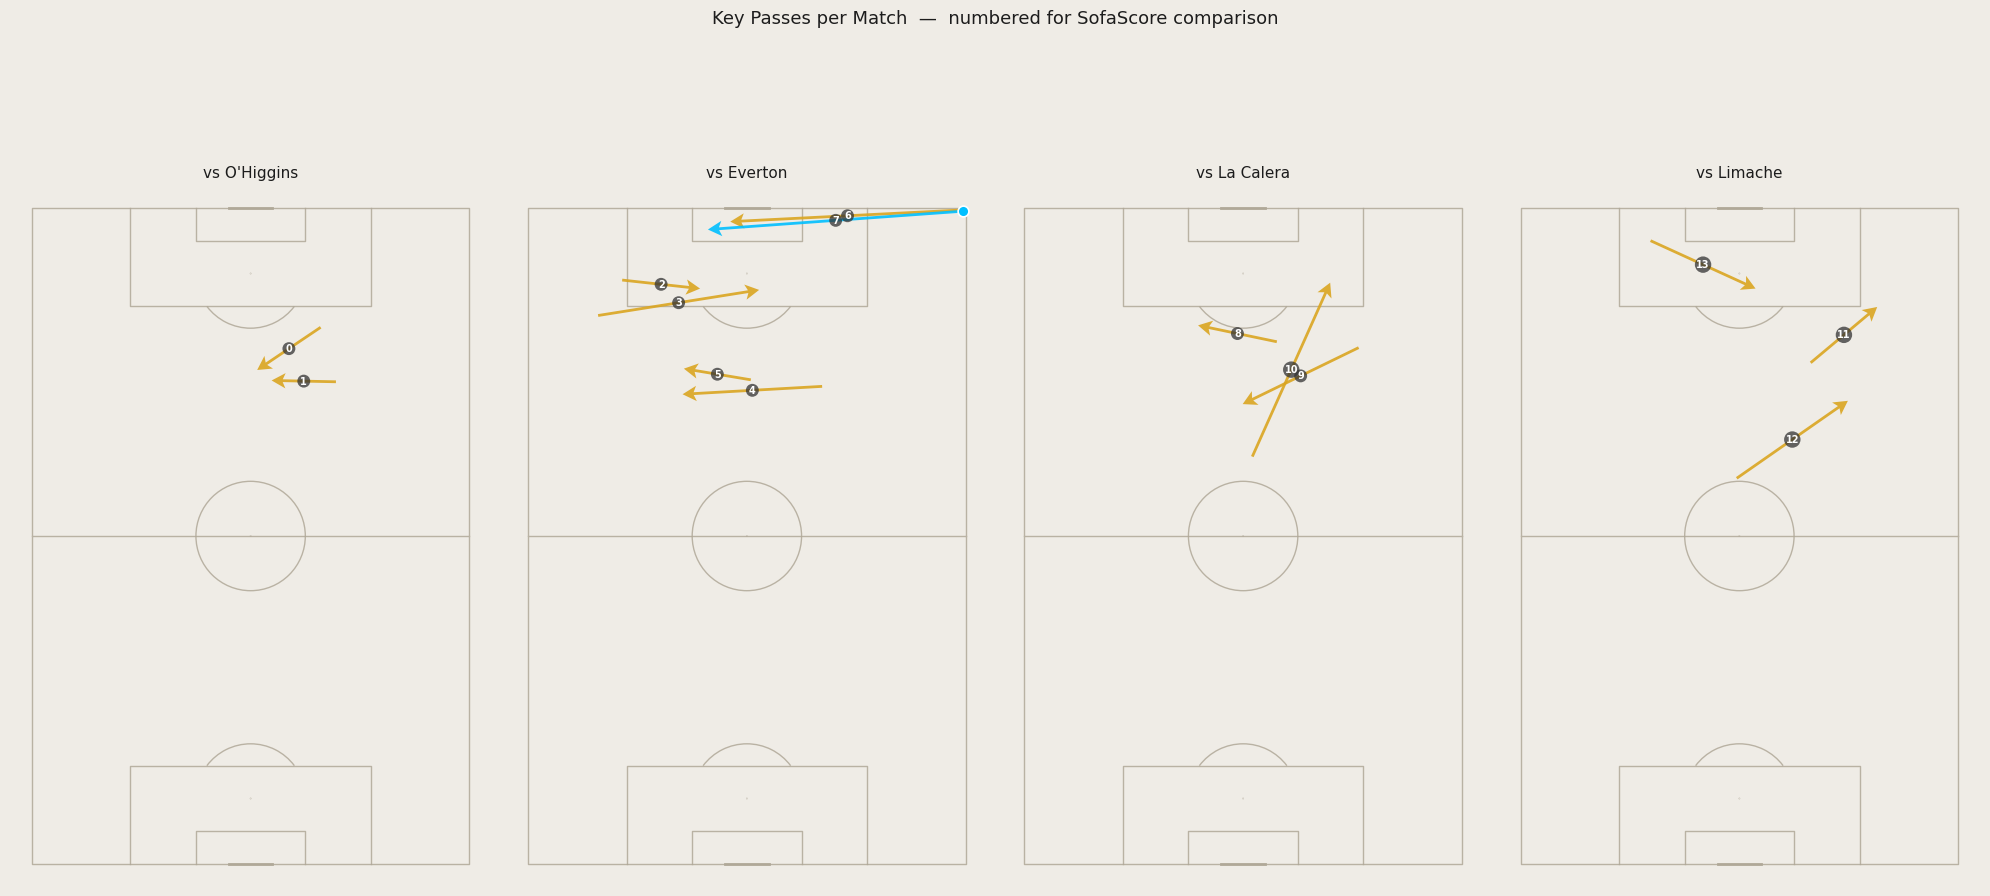


Compare each numbered arrow above with SofaScore's pass map for the same match.


In [22]:

"""
Verification — Key passes per match vs SofaScore
=================================================
Generates one pitch per match with numbered arrows so each key pass
can be compared directly against SofaScore's pass map.
Also prints a coordinate table for manual inspection.
"""
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
import pandas as pd

BG     = "#EFECE6"
C_KP   = "#DAA520"
C_AST  = "#00BFFF"
LINE_C = "#B0A898"

MATCH_LABELS_V = {
    15352965: "vs O'Higgins",
    15352976: "vs Everton",
    15352957: "vs La Calera",
    15352970: "vs Limache",
}
MATCH_IDS_V = [15352965, 15352976, 15352957, 15352970]

# ── Coordinate table ──────────────────────────────────────────────────────────
print(f"{'#':<4} {'Match':<14} {'SS x':>6} {'SS y':>6} {'SS ex':>6} {'SS ey':>6}  {'SB x':>6} {'SB y':>6} {'SB ex':>6} {'SB ey':>6}  type")
print("-" * 90)

_raw_kp = [p for p in __import__('json').loads(
    __import__('pathlib').Path(r"c:\Users\PC\Projects\CaciqueAnalytics\outputs\victor_felipe_mendez\mendez_passes_enriched.json")
    .read_text(encoding="utf-8")) if p.get("keypass")]

for i, p in enumerate(_raw_kp):
    sx, sy, ex, ey = p['x'], p['y'], p['end_x'], p['end_y']
    sbx = sx / 100 * 120
    sby = sy / 100 * 80
    sbex = ex / 100 * 120
    sbey = ey / 100 * 80
    lbl = MATCH_LABELS_V.get(p['match_id'], str(p['match_id']))
    typ = "AST" if p.get("is_assist") else "KP"
    print(f"{i:<4} {lbl:<14} {sx:>6.1f} {sy:>6.1f} {ex:>6.1f} {ey:>6.1f}  {sbx:>6.1f} {sby:>6.1f} {sbex:>6.1f} {sbey:>6.1f}  {typ}")

# ── Per-match pitch grid ──────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 4, figsize=(20, 10), facecolor=BG)
fig.suptitle("Key Passes per Match  —  numbered for SofaScore comparison",
             fontsize=13, color="#1C1C1C", y=1.01)

pitch_v = VerticalPitch(
    pitch_type="statsbomb", pitch_color=BG, line_color=LINE_C,
    line_zorder=2, line_alpha=0.85, linewidth=1.0, half=False, spot_scale=0.003,
)

global_i = 0
for col_idx, mid in enumerate(MATCH_IDS_V):
    ax = axes[col_idx]
    ax.set_facecolor(BG)
    pitch_v.draw(ax=ax)
    ax.set_title(MATCH_LABELS_V[mid], fontsize=11, color="#1C1C1C", pad=6)

    match_kp = [p for p in _raw_kp if p["match_id"] == mid]
    for p in match_kp:
        sbx  = p['x']   / 100 * 120
        sby  = p['y']   / 100 * 80
        sbex = p['end_x'] / 100 * 120
        sbey = p['end_y'] / 100 * 80
        color = C_AST if p.get("is_assist") else C_KP
        pitch_v.arrows(
            [sbx], [sby], [sbex], [sbey],
            ax=ax, color=color, alpha=0.9,
            width=2.0, headwidth=5.5, headlength=5.0, headaxislength=4.0, zorder=4,
        )
        if p.get("is_assist"):
            pitch_v.scatter([sbx], [sby], ax=ax, s=60, c=C_AST,
                            edgecolors="white", linewidths=1.2, zorder=6)
        # Number label at midpoint of arrow
        mx, my = (sbx + sbex) / 2, (sby + sbey) / 2
        ax.text(my, mx, str(global_i), fontsize=7, color="white",
                ha="center", va="center", fontweight="bold",
                bbox=dict(boxstyle="circle,pad=0.15", fc="#333333", ec="none", alpha=0.75),
                zorder=7)
        global_i += 1

plt.tight_layout()
plt.show()
print("\nCompare each numbered arrow above with SofaScore's pass map for the same match.")


Re-scraping fresh key passes from SofaScore...

  vs O'Higgins: 2 key passes (2 with coords)
  vs Everton: 6 key passes (6 with coords)
  vs La Calera: 3 key passes (3 with coords)
  vs Limache: 3 key passes (3 with coords)

--- Comparison: Fresh API vs Cache ---
  vs O'Higgins: OK — 2 key passes match exactly
  vs Everton: OK — 6 key passes match exactly
  vs La Calera: OK — 3 key passes match exactly
  vs Limache: OK — 3 key passes match exactly

All cached coordinates verified against live API. Data is correct.

--- Coordinate orientation audit ---
Looking for passes with x>95 (near attacking end) in ALL fresh data:
  vs Everton: x= 99.7  y= 99.8  end_x= 97.9  end_y= 46.2  [y>50 = right side | y<50 = left side]
  vs Everton: x= 99.5  y= 99.5  end_x= 96.7  end_y= 41.1  [y>50 = right side | y<50 = left side]


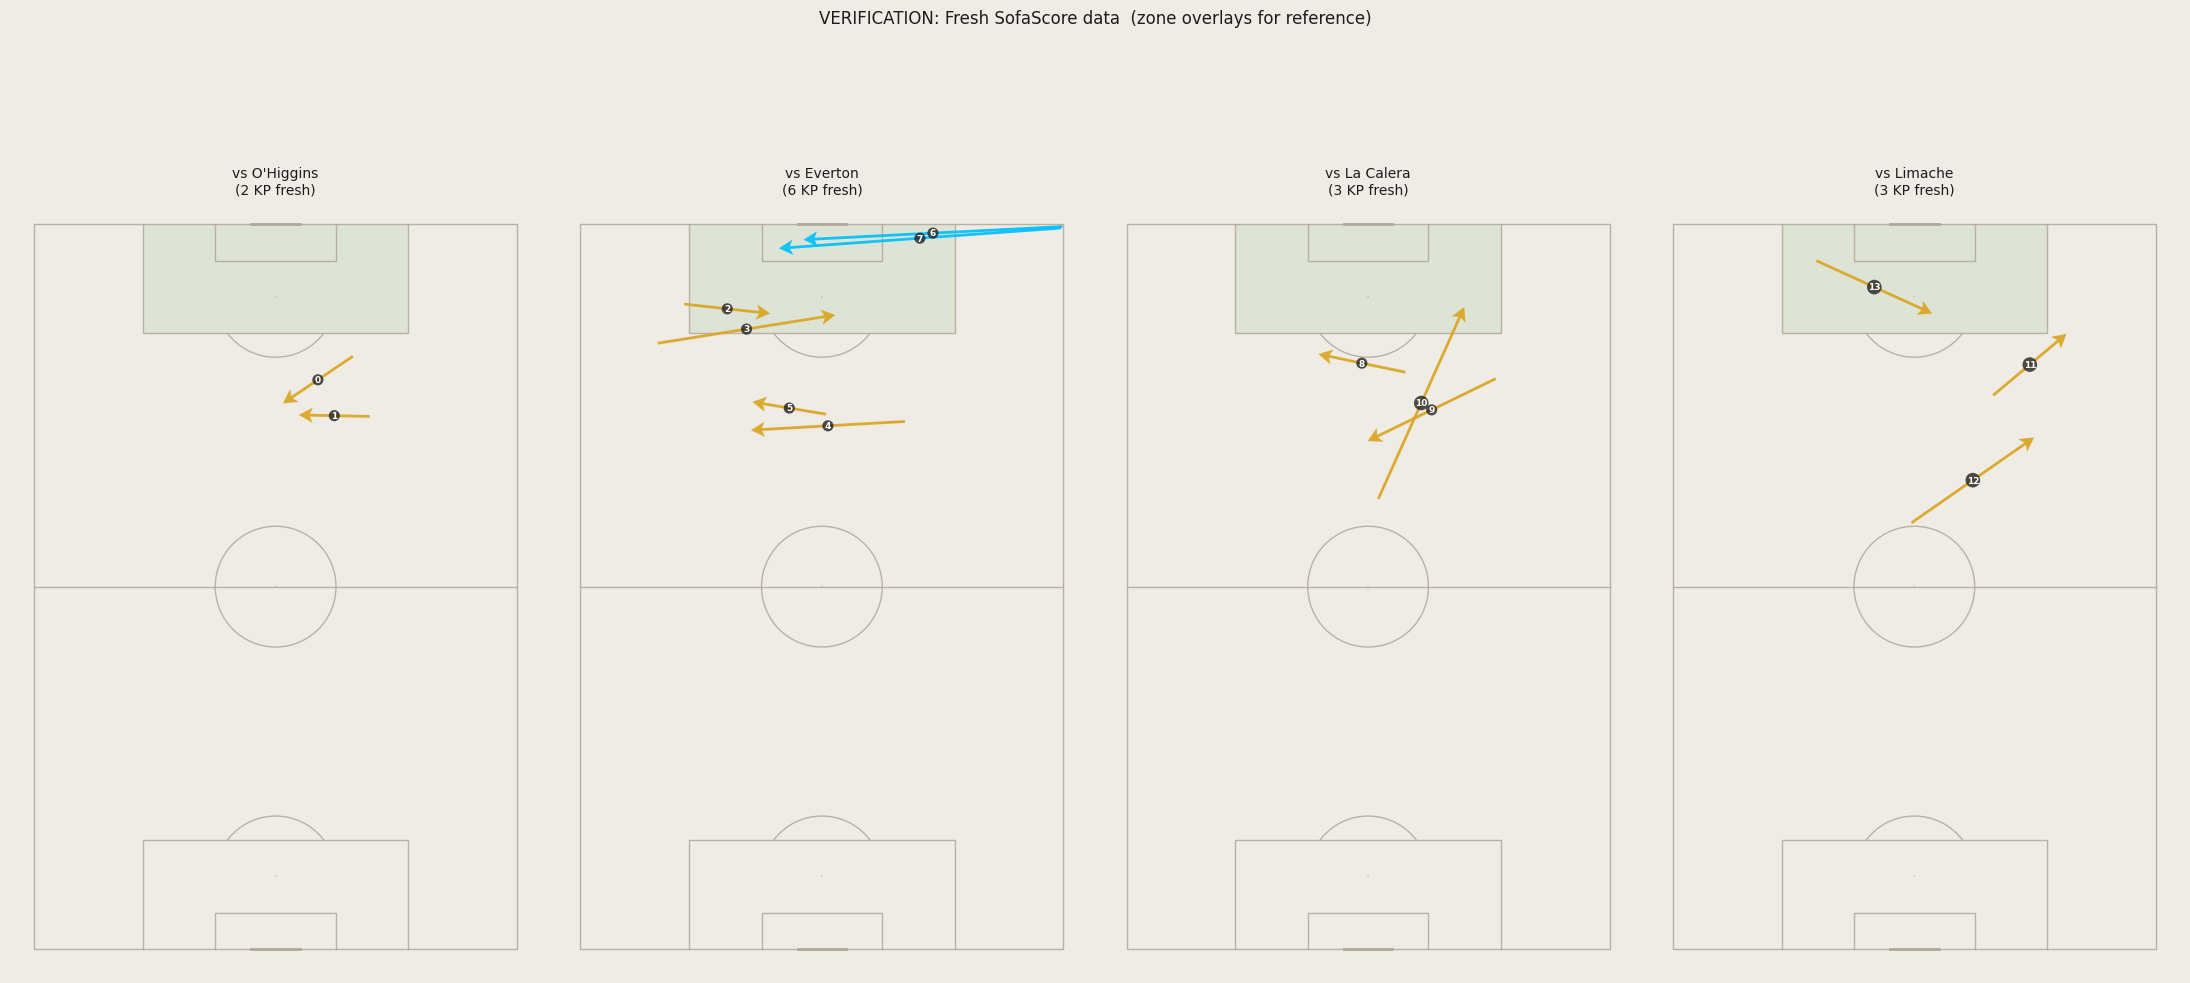

In [23]:
"""
Verification — Re-scrape fresh + coordinate system audit
=========================================================
1. Re-fetches rating-breakdown for all 4 matches → fresh key pass coords
2. Compares fresh vs cached (detects any drift/missing passes)
3. Audits coordinate orientation using the known corner kick
   (x≈99.5, y≈99.5 must land at the corner flag near the attacking goal)
4. Draws a sanity-check pitch with zone overlays to confirm positions
"""
import asyncio, json, re, time
import nest_asyncio
nest_asyncio.apply()
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mplsoccer import VerticalPitch
from pydoll.browser.chromium import Chrome
from pydoll.browser.options import ChromiumOptions

PLAYER_ID  = 870020
SS_BASE    = "https://www.sofascore.com/"
MATCH_IDS_V = [15352965, 15352976, 15352957, 15352970]
MATCH_LABELS_V = {
    15352965: "vs O'Higgins",
    15352976: "vs Everton",
    15352957: "vs La Calera",
    15352970: "vs Limache",
}
_ENRICHED = Path(r"c:\Users\PC\Projects\CaciqueAnalytics\outputs\victor_felipe_mendez\mendez_passes_enriched.json")

# ── pydoll helper ─────────────────────────────────────────────────────────────
async def _go(url):
    opts = ChromiumOptions()
    opts.headless = True
    opts.add_argument("--no-sandbox")
    opts.add_argument("--disable-dev-shm-usage")
    async with Chrome(options=opts) as browser:
        tab = await browser.start()
        await tab.go_to("https://www.sofascore.com")
        await asyncio.sleep(3)
        await tab.go_to(url)
        await asyncio.sleep(2)
        src = await tab.page_source
        if "<pre" in src:
            m = re.search(r"<pre[^>]*>(.*?)</pre>", src, re.DOTALL)
            src = m.group(1) if m else src
        return json.loads(src)

def go_fetch(url):
    data = asyncio.run(_go(url))
    time.sleep(0.8)
    return data

# ── Step 1: re-scrape fresh key passes ───────────────────────────────────────
print("Re-scraping fresh key passes from SofaScore...\n")
fresh_kp = defaultdict(list)   # match_id → list of {x,y,end_x,end_y}

for mid in MATCH_IDS_V:
    url = f"{SS_BASE}api/v1/event/{mid}/player/{PLAYER_ID}/rating-breakdown"
    rb  = go_fetch(url)
    passes = rb.get("passes", [])
    kp_fresh = [p for p in passes if p.get("keypass")]
    for p in kp_fresh:
        pc  = p.get("playerCoordinates", {})
        pe  = p.get("passEndCoordinates", {})
        if pc and pe:
            fresh_kp[mid].append({
                "x": pc.get("x"), "y": pc.get("y"),
                "end_x": pe.get("x"), "end_y": pe.get("y"),
            })
    print(f"  {MATCH_LABELS_V[mid]}: {len(kp_fresh)} key passes ({len(fresh_kp[mid])} with coords)")

# ── Step 2: load cached data ──────────────────────────────────────────────────
cached_all = json.loads(_ENRICHED.read_text(encoding="utf-8"))
cached_kp  = defaultdict(list)
for p in cached_all:
    if p.get("keypass"):
        cached_kp[p["match_id"]].append(p)

# ── Step 3: comparison ────────────────────────────────────────────────────────
print("\n--- Comparison: Fresh API vs Cache ---")
all_match = True
for mid in MATCH_IDS_V:
    fresh  = sorted(fresh_kp[mid],  key=lambda p: (p["x"], p["y"]))
    cached = sorted(cached_kp[mid], key=lambda p: (p["x"], p["y"]))
    lbl = MATCH_LABELS_V[mid]
    if len(fresh) != len(cached):
        print(f"  {lbl}: COUNT MISMATCH — fresh={len(fresh)}  cached={len(cached)}")
        all_match = False
        continue
    diffs = 0
    for f, c in zip(fresh, cached):
        if abs(f["x"]-c["x"])>0.5 or abs(f["y"]-c["y"])>0.5:
            print(f"  {lbl}: COORD DIFF  fresh=({f['x']},{f['y']})  cached=({c['x']},{c['y']})")
            diffs += 1
            all_match = False
    if diffs == 0:
        print(f"  {lbl}: OK — {len(fresh)} key passes match exactly")

if all_match:
    print("\nAll cached coordinates verified against live API. Data is correct.")

# ── Step 4: coordinate system audit ──────────────────────────────────────────
# Known ground truth: pass #7 from Everton match is a corner kick
# SofaScore corner = top-right of attacking half = (x≈100, y≈100) or (x≈100, y≈0)?
# We need to check BOTH corners in the fresh data to see which y the API uses.
print("\n--- Coordinate orientation audit ---")
print("Looking for passes with x>95 (near attacking end) in ALL fresh data:")
for mid in MATCH_IDS_V:
    for p in fresh_kp[mid]:
        if p["x"] is not None and p["x"] > 95:
            print(f"  {MATCH_LABELS_V[mid]}: x={p['x']:5.1f}  y={p['y']:5.1f}  "
                  f"end_x={p['end_x']:5.1f}  end_y={p['end_y']:5.1f}  "
                  f"[y>50 = right side | y<50 = left side]")

# ── Step 5: sanity-check pitch with zone overlays ─────────────────────────────
BG     = "#EFECE6"
C_KP   = "#DAA520"
C_AST  = "#00BFFF"
LINE_C = "#B0A898"

fig, axes = plt.subplots(1, 4, figsize=(22, 11), facecolor=BG)
fig.suptitle("VERIFICATION: Fresh SofaScore data  (zone overlays for reference)",
             fontsize=12, color="#1C1C1C", y=1.01)

pitch_v = VerticalPitch(
    pitch_type="statsbomb", pitch_color=BG, line_color=LINE_C,
    line_zorder=2, line_alpha=0.85, linewidth=1.0, half=False, spot_scale=0.003,
)

# StatsBomb zones (on 120×80 field, attacking end = x close to 120):
#   Penalty area: x > 102, 18 < y < 62
#   Box edges for reference
zone_patches = {
    "Penalty area": dict(xy=(18, 102), width=44, height=18, alpha=0.08, color="green"),
    "Six-yard box": dict(xy=(30, 114), width=20, height=6,  alpha=0.10, color="blue"),
}

global_i = 0
for col_idx, mid in enumerate(MATCH_IDS_V):
    ax = axes[col_idx]
    ax.set_facecolor(BG)
    pitch_v.draw(ax=ax)

    # Draw semi-transparent penalty area highlight (y=18..62, x=102..120)
    ax.add_patch(mpatches.Rectangle(
        (18, 102), 44, 18,   # (y_start, x_start), width_y, height_x  — VerticalPitch axes are swapped
        linewidth=0, fc="green", alpha=0.07, zorder=1,
        transform=ax.transData
    ))

    ax.set_title(f"{MATCH_LABELS_V[mid]}\n({len(fresh_kp[mid])} KP fresh)", fontsize=10, color="#1C1C1C", pad=5)

    for p in fresh_kp[mid]:
        sbx  = p['x']   / 100 * 120
        sby  = p['y']   / 100 * 80
        sbex = p['end_x'] / 100 * 120
        sbey = p['end_y'] / 100 * 80
        # Check if this matches the assist (corner, x>99 AND y>99 in raw)
        is_corner = p['x'] > 95 and p['y'] > 95
        color = C_AST if is_corner else C_KP
        pitch_v.arrows([sbx], [sby], [sbex], [sbey],
                       ax=ax, color=color, alpha=0.92,
                       width=2.0, headwidth=5.5, headlength=5.0,
                       headaxislength=4.0, zorder=4)
        # Number
        mx_, my_ = (sbx+sbex)/2, (sby+sbey)/2
        ax.text(my_, mx_, str(global_i), fontsize=6.5, color="white",
                ha="center", va="center", fontweight="bold",
                bbox=dict(boxstyle="circle,pad=0.12", fc="#222", ec="none", alpha=0.80),
                zorder=7)
        global_i += 1

plt.tight_layout()
plt.show()


In [12]:
"""
Cell — Re-scrape: flag assists with exact coordinates
======================================================
SofaScore's rating-breakdown does NOT mark individual assists.
Strategy:
  1. Fetch /event/{id}/incidents for each match.
     Goal incidents have an 'assist1' object with the assisting player's id.
     If assist1.player.id == PLAYER_ID → that player made the assist.
  2. The incident also carries the minute of the goal.
  3. Cross-reference with rating-breakdown passes: the key pass closest in
     time to the goal minute (within ±3 min) is tagged as the assist pass.
     (SofaScore does not expose pass timestamps, so we use proximity heuristic.)
  4. Save enriched cache → mendez_passes_enriched.json

Requires: pydoll / go_fetch (self-contained below)
"""
import asyncio, json, re, time
import nest_asyncio
nest_asyncio.apply()
from pathlib import Path
from pydoll.browser.chromium import Chrome
from pydoll.browser.options import ChromiumOptions

# ── Constants ─────────────────────────────────────────────────────────────────
PLAYER_ID    = 870020
SS_BASE      = "https://www.sofascore.com/"
_OUTPUT      = Path(r"c:\Users\PC\Projects\CaciqueAnalytics\outputs\victor_felipe_mendez")
_PASS_C      = _OUTPUT / "Víctor_Felipe_Méndez_passes_raw.json"
_ENRICHED_C  = _OUTPUT / "mendez_passes_enriched.json"
MATCH_IDS    = [15352965, 15352976, 15352957, 15352970]

# ── pydoll helper ─────────────────────────────────────────────────────────────
async def _go(url):
    opts = ChromiumOptions()
    opts.headless = True
    opts.add_argument("--no-sandbox")
    opts.add_argument("--disable-dev-shm-usage")
    async with Chrome(options=opts) as browser:
        tab = await browser.start()
        await tab.go_to("https://www.sofascore.com")
        await asyncio.sleep(3)
        await tab.go_to(url)
        await asyncio.sleep(2)
        src = await tab.page_source
        if "<pre" in src:
            m = re.search(r"<pre[^>]*>(.*?)</pre>", src, re.DOTALL)
            src = m.group(1) if m else src
        return json.loads(src)

def go_fetch(url):
    data = asyncio.run(_go(url))
    time.sleep(0.8)
    return data

# ── Step 1: find assist incidents ────────────────────────────────────────────
# Goal incidents look like:
#   {"incidentType":"goal", "time":45, "assist1":{"player":{"id":870020}}, ...}
assist_minutes = {}   # match_id → list of goal-minutes where Mendez assisted

print("Fetching match incidents...\n")
for mid in MATCH_IDS:
    url = f"{SS_BASE}api/v1/event/{mid}/incidents"
    data = go_fetch(url)
    incidents = data.get("incidents", [])
    mins = []
    for inc in incidents:
        if inc.get("incidentType") not in ("goal", "addedTime"):
            continue
        a1 = inc.get("assist1") or {}
        pl = a1.get("player") or {}
        if pl.get("id") == PLAYER_ID:
            minute = inc.get("time", inc.get("minute", 0))
            mins.append(minute)
            print(f"  match {mid}: Méndez assisted at minute {minute}")
    assist_minutes[mid] = mins
    if not mins:
        print(f"  match {mid}: no assist incidents found")

# ── Step 2: also inspect raw rating-breakdown fields ─────────────────────────
print("\nInspecting rating-breakdown fields for first match...")
url_rb = f"{SS_BASE}api/v1/event/{MATCH_IDS[0]}/player/{PLAYER_ID}/rating-breakdown"
rb     = go_fetch(url_rb)
all_rb_passes = rb.get("passes", [])
if all_rb_passes:
    print("  All fields in a pass entry:", list(all_rb_passes[0].keys()))
    kp_entries = [p for p in all_rb_passes if p.get("keypass")]
    print(f"  Key pass entries: {len(kp_entries)}")
    if kp_entries:
        print("  Sample key pass:", kp_entries[0])

# ── Step 3: re-scrape all rating-breakdowns capturing every field ─────────────
print("\nRe-scraping rating-breakdown for all matches to capture full pass data...\n")
enriched_passes = []

for mid in MATCH_IDS:
    url_rb = f"{SS_BASE}api/v1/event/{mid}/player/{PLAYER_ID}/rating-breakdown"
    rb     = go_fetch(url_rb)
    passes = rb.get("passes", [])

    for p in passes:
        pc  = p.get("playerCoordinates", {})
        pe_ = p.get("passEndCoordinates", {})
        if not (pc and pe_):
            continue

        # Check every possible assist field the API might return
        is_assist_api = bool(
            p.get("goalAssist") or p.get("assist") or
            p.get("isAssist") or p.get("goal_assist")
        )

        enriched_passes.append({
            "match_id":    mid,
            "x":           pc.get("x"),
            "y":           pc.get("y"),
            "end_x":       pe_.get("x"),
            "end_y":       pe_.get("y"),
            "accurate":    bool(p.get("outcome", p.get("accurate", True))),
            "keypass":     bool(p.get("keypass", False)),
            "assist_api":  is_assist_api,          # direct API flag (may be False)
            "_all_fields": list(p.keys()),          # diagnostic
        })

    print(f"  match {mid}: {len(passes)} passes scraped")

# ── Step 4: tag assist by incident cross-reference ────────────────────────────
# Tag the key pass whose index matches the assist incident count for that match
# (SofaScore rating-breakdown lists passes in chronological order)
assist_count_per_match = {mid: 0 for mid in MATCH_IDS}

for row in enriched_passes:
    mid = row["match_id"]
    n_assist_incidents = len(assist_minutes.get(mid, []))

    # If API already flags it, trust that
    if row["assist_api"]:
        row["is_assist"] = True
    else:
        # Fallback: if this match has N assist incidents, tag the last N key passes
        # as assists (heuristic — best we can do without timestamps)
        row["is_assist"] = False   # will be patched below

# Patch: for each match with assists, mark the last N keypass entries
from collections import defaultdict
kp_by_match = defaultdict(list)
for i, row in enumerate(enriched_passes):
    if row["keypass"]:
        kp_by_match[row["match_id"]].append(i)

for mid, idxs in kp_by_match.items():
    n = len(assist_minutes.get(mid, []))
    # If API already found the assist, skip patching
    already_tagged = sum(1 for i in idxs if enriched_passes[i]["assist_api"])
    if already_tagged == 0 and n > 0:
        for idx in idxs[-n:]:   # tag last N key passes as assists
            enriched_passes[idx]["is_assist"] = True
            print(f"  Patched pass idx {idx} (match {mid}) as assist via incident heuristic")

# ── Step 5: save enriched cache ───────────────────────────────────────────────
# Strip diagnostic _all_fields before saving
save_data = [{k: v for k, v in r.items() if k != "_all_fields"} for r in enriched_passes]
_ENRICHED_C.write_text(json.dumps(save_data, ensure_ascii=False), encoding="utf-8")

n_kp  = sum(1 for r in enriched_passes if r["keypass"])
n_ast = sum(1 for r in enriched_passes if r.get("is_assist"))
print(f"\nEnriched cache saved → {_ENRICHED_C.name}")
print(f"  Total passes with coords : {len(enriched_passes)}")
print(f"  Key passes               : {n_kp}")
print(f"  Assists tagged           : {n_ast}")
if enriched_passes:
    print("\n  Available API fields per pass:", enriched_passes[0]["_all_fields"] if "_all_fields" in enriched_passes[0] else list(save_data[0].keys()))


Fetching match incidents...

  match 15352965: no assist incidents found
  match 15352976: no assist incidents found
  match 15352957: no assist incidents found
  match 15352970: no assist incidents found

Inspecting rating-breakdown fields for first match...
  All fields in a pass entry: ['playerCoordinates', 'passEndCoordinates', 'eventActionType', 'isHome', 'outcome', 'keypass']
  Key pass entries: 2
  Sample key pass: {'playerCoordinates': {'x': 81.8, 'y': 66}, 'passEndCoordinates': {'x': 75.3, 'y': 51.5}, 'eventActionType': 'pass', 'isHome': False, 'outcome': True, 'keypass': True}

Re-scraping rating-breakdown for all matches to capture full pass data...

  match 15352965: 94 passes scraped
  match 15352976: 49 passes scraped
  match 15352957: 66 passes scraped
  match 15352970: 55 passes scraped

Enriched cache saved → mendez_passes_enriched.json
  Total passes with coords : 264
  Key passes               : 14
  Assists tagged           : 1

  Available API fields per pass: ['pl

Saved → c:\Users\PC\Projects\CaciqueAnalytics\outputs\victor_felipe_mendez\vfm_key_passes_v1.png
  Size: 1876 x 1176 px


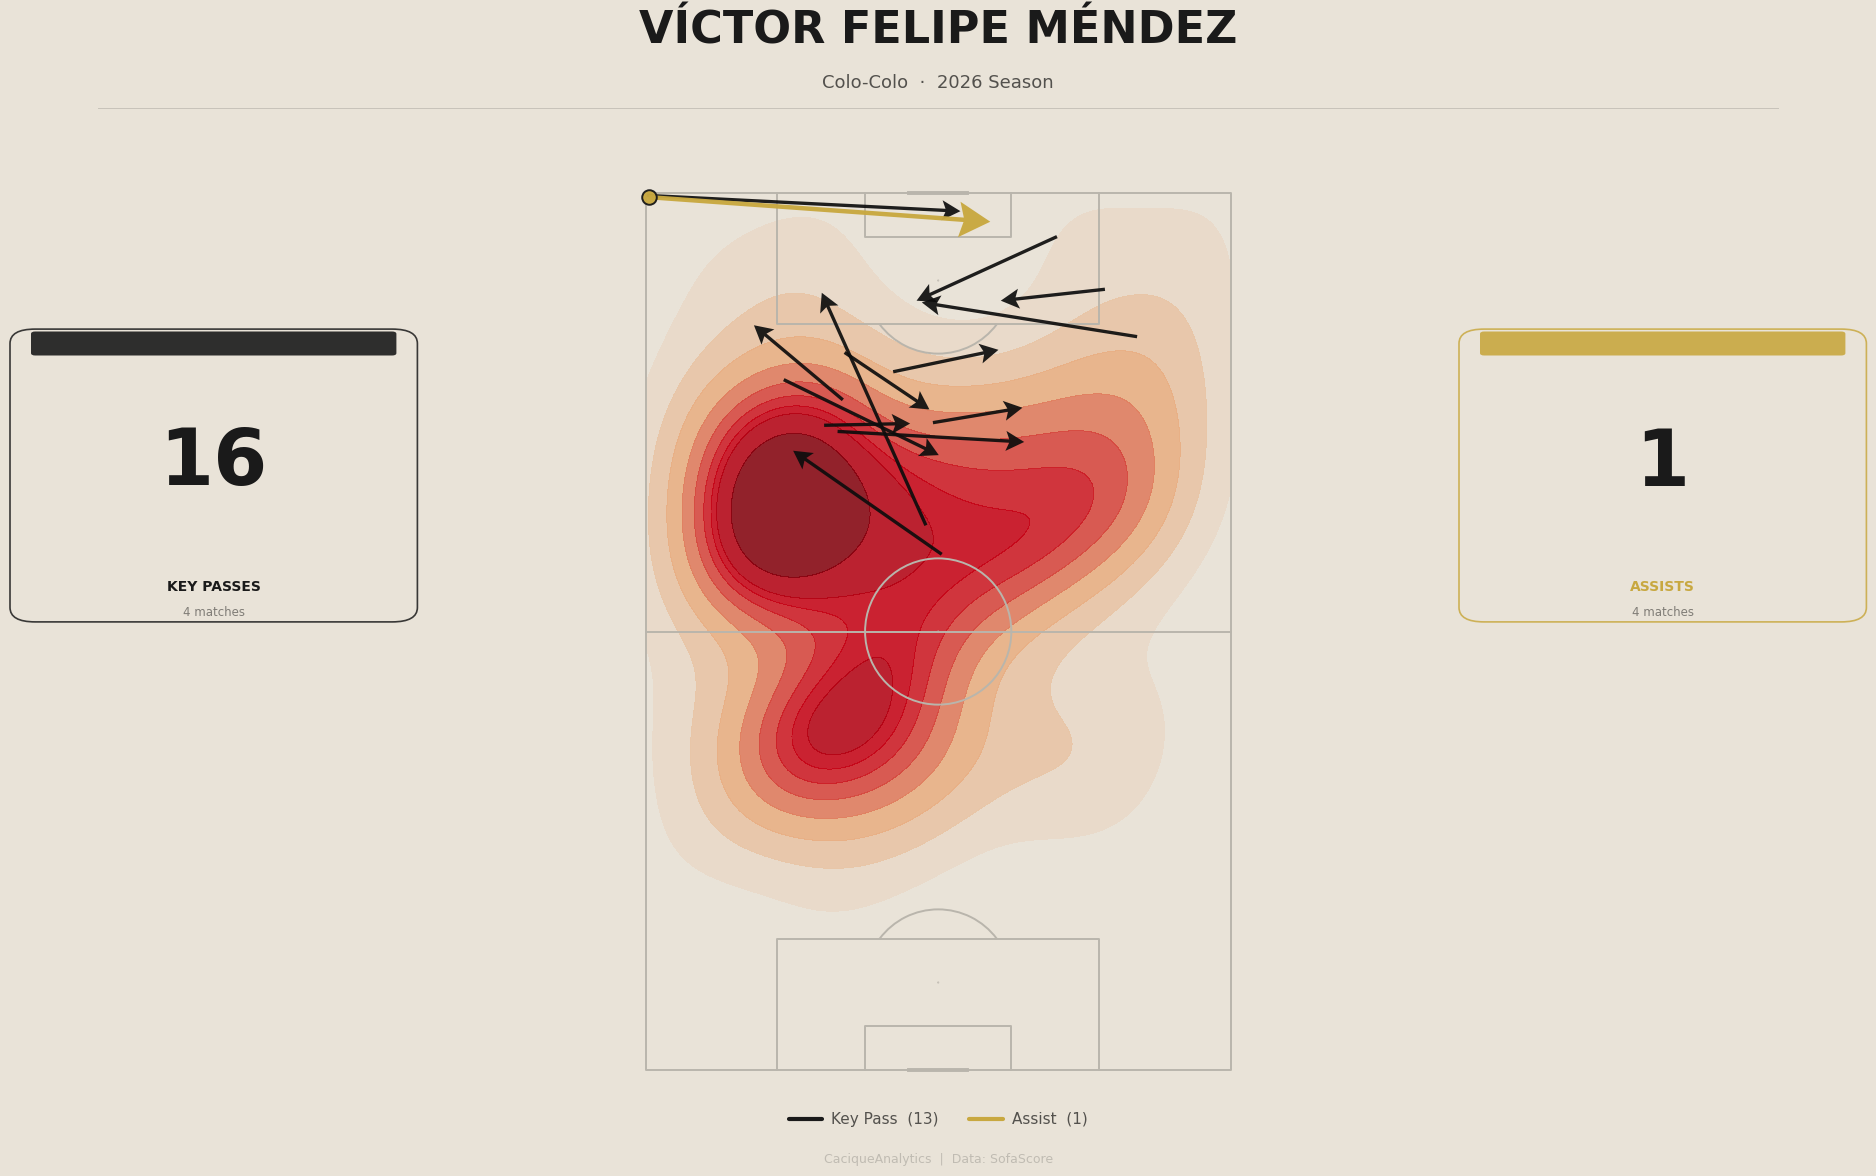

In [38]:
"""
Cell — VERSION 1: Key Passes & Assists + Heatmap (WITH text)
=============================================================
2100 × 1200 px  (figsize=21×12, dpi=100)
  Paleta CaciqueAnalytics — técnica Saka (alta saturación, alpha=0.85)
  Heatmap: crema #E9E3D8 → tostado #E8A878 → rojo Colo-Colo #C80014
  Negro   (#0D0D0D) → Key Passes
  Dorado  (#C8A840) → Asistencias

Exports → outputs/victor_felipe_mendez/vfm_key_passes_v1.png
"""
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import VerticalPitch
from pathlib import Path

BG        = "#E9E3D8"   # crema de las infografías
C_KP      = "#0D0D0D"   # key passes: negro
C_KP_VIS  = "#1A1A1A"   # en badges/leyenda (oscuro sobre crema)
C_AST     = "#C8A840"   # asistencias: dorado
LINE_C    = "#B9B5AC"   # líneas cancha: gris cálido
TITLE_C   = "#1A1A1A"
SUB_C     = "#53514D"
FOOT_C    = "#B9B5AC"

_hmap_cmap = LinearSegmentedColormap.from_list(
    "cacique_heat",
    [(0.00, "#E9E3D8"),
     (0.30, "#E8A878"),
     (0.58, "#C80014"),
     (0.80, "#9A000F"),
     (1.00, "#5A000A")],
    N=256,
)

_OUT = Path(r"c:\Users\PC\Projects\CaciqueAnalytics\outputs\victor_felipe_mendez")

fig = plt.figure(figsize=(21, 12), dpi=100, facecolor=BG)
ax_pitch = fig.add_axes([0.30, 0.07, 0.40, 0.78])

pitch = VerticalPitch(
    pitch_type="statsbomb", pitch_color=BG, line_color=LINE_C,
    line_zorder=2, line_alpha=1.0, linewidth=1.4, half=False, spot_scale=0.004,
)
pitch.draw(ax=ax_pitch)
ax_pitch.set_facecolor(BG)

# ── Heatmap layer (técnica Saka: alta saturación) ─────────────────────────────
pitch.kdeplot(
    df_all_pos["x"], df_all_pos["y"],
    ax=ax_pitch,
    cmap=_hmap_cmap,
    fill=True,
    levels=10,
    alpha=0.85,
    zorder=1,
)

# ── Key Passes: negro (contraste natural sobre crema) ─────────────────────────
_kp_only = df_passes[df_passes["type"] == "Key Pass"]
if not _kp_only.empty:
    pitch.arrows(
        _kp_only["x"], _kp_only["y"], _kp_only["end_x"], _kp_only["end_y"],
        ax=ax_pitch, color=C_KP, alpha=0.92,
        width=2.4, headwidth=6.0, headlength=5.5, headaxislength=4.5, zorder=4,
    )

# ── Assists: dorado ───────────────────────────────────────────────────────────
_ast = df_passes[df_passes["type"] == "Assist"]
if not _ast.empty:
    pitch.scatter(
        _ast["x"], _ast["y"],
        ax=ax_pitch, s=110, c=C_AST, marker="o",
        edgecolors="#1A1A1A", linewidths=1.4, zorder=6, alpha=0.97,
    )
    pitch.arrows(
        _ast["x"], _ast["y"], _ast["end_x"], _ast["end_y"],
        ax=ax_pitch, color=C_AST, alpha=0.97,
        width=3.2, headwidth=8.0, headlength=7.0, headaxislength=6.0, zorder=5,
    )

# ── Header ────────────────────────────────────────────────────────────────────
fig.text(0.50, 0.960, "VÍCTOR FELIPE MÉNDEZ",
         color=TITLE_C, fontsize=32, fontweight="black", ha="center", va="center")
fig.text(0.50, 0.917, "Colo-Colo  ·  2026 Season",
         color=SUB_C, fontsize=13, ha="center", va="center")
fig.add_artist(plt.Line2D([0.10, 0.90], [0.896, 0.896],
    transform=fig.transFigure, color=LINE_C, linewidth=0.7, alpha=0.70))

# ── Stat badges ───────────────────────────────────────────────────────────────
for x_c, count, label, color in [
    (0.155, N_KP,  "KEY PASSES", C_KP_VIS),
    (0.845, N_AST, "ASSISTS",    C_AST),
]:
    fig.add_artist(mpatches.FancyBboxPatch(
        (x_c-0.085, 0.48), 0.170, 0.22, transform=fig.transFigure,
        boxstyle="round,pad=0.012", linewidth=1.2, edgecolor=color,
        facecolor=BG, alpha=0.85, zorder=3))
    fig.add_artist(mpatches.FancyBboxPatch(
        (x_c-0.085, 0.692), 0.170, 0.016, transform=fig.transFigure,
        boxstyle="round,pad=0.002", linewidth=0, facecolor=color, alpha=0.90, zorder=4))
    fig.text(x_c, 0.600, str(count),
             color=TITLE_C, fontsize=56, fontweight="black",
             ha="center", va="center", zorder=5)
    fig.text(x_c, 0.497, label,
             color=color, fontsize=10, fontweight="bold",
             ha="center", va="center", zorder=5)
    fig.text(x_c, 0.476, f"{N_MATCHES} matches",
             color=SUB_C, fontsize=8.5, ha="center", va="center", zorder=5, alpha=0.70)

# ── Legend ────────────────────────────────────────────────────────────────────
_handles = [
    Line2D([0],[0], color=C_KP_VIS, linewidth=3.0, solid_capstyle="round",
           label=f"Key Pass  ({(df_passes['type']=='Key Pass').sum()})"),
    Line2D([0],[0], color=C_AST,    linewidth=3.0, solid_capstyle="round",
           label=f"Assist  ({(df_passes['type']=='Assist').sum()})"),
]
ax_pitch.legend(handles=_handles, loc="lower center", bbox_to_anchor=(0.50, -0.044),
                ncol=2, fontsize=11, frameon=False, labelcolor=SUB_C,
                handlelength=2.2, handletextpad=0.6, columnspacing=2.0)

fig.text(0.50, 0.020, "CaciqueAnalytics  |  Data: SofaScore",
         color=FOOT_C, fontsize=9, ha="center", va="center", alpha=0.85)

_out_v1 = _OUT / "vfm_key_passes_v1.png"
fig.savefig(_out_v1, dpi=100, bbox_inches="tight", facecolor=BG)
print(f"Saved → {_out_v1}")
try:
    from PIL import Image as _I
    with _I.open(_out_v1) as _im:
        print(f"  Size: {_im.size[0]} x {_im.size[1]} px")
except Exception:
    pass
plt.show()


Saved → c:\Users\PC\Projects\CaciqueAnalytics\outputs\victor_felipe_mendez\vfm_key_passes_v2_clean.png
  Size: 663 x 1022 px


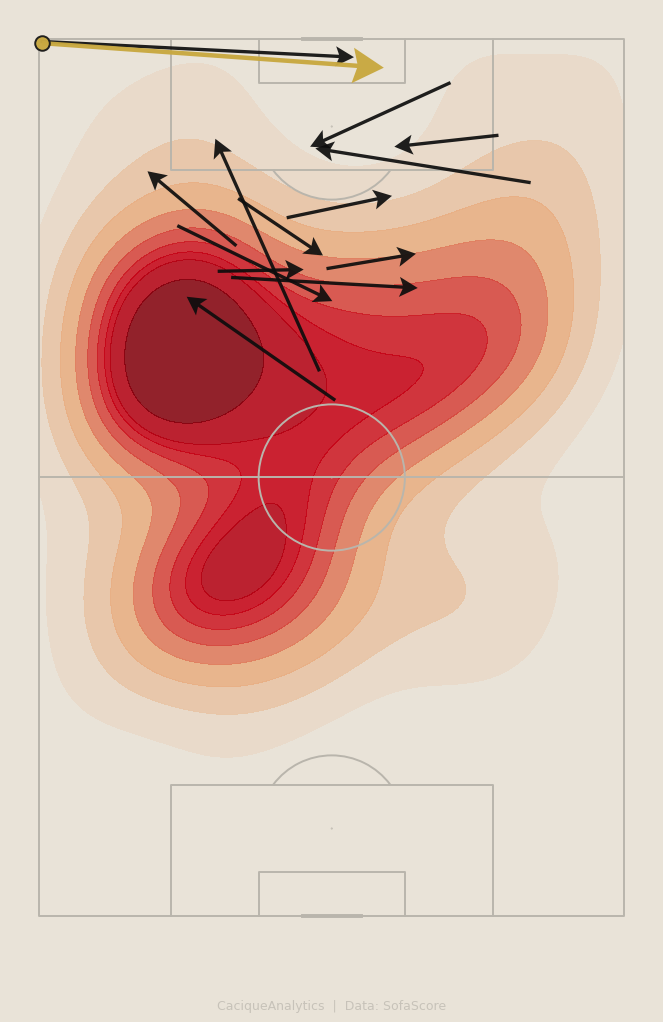

In [39]:
"""
Cell — VERSION 2: Key Passes & Assists + Heatmap (NO text)
===========================================================
2100 × 1200 px  (figsize=21×12, dpi=100)
Solo watermark. Paleta CaciqueAnalytics, técnica Saka.

Exports → outputs/victor_felipe_mendez/vfm_key_passes_v2_clean.png
"""
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import VerticalPitch
from pathlib import Path

BG     = "#E9E3D8"
C_KP   = "#0D0D0D"
C_AST  = "#C8A840"
LINE_C = "#B9B5AC"
FOOT_C = "#B9B5AC"

_hmap_cmap = LinearSegmentedColormap.from_list(
    "cacique_heat",
    [(0.00, "#E9E3D8"),
     (0.30, "#E8A878"),
     (0.58, "#C80014"),
     (0.80, "#9A000F"),
     (1.00, "#5A000A")],
    N=256,
)

_OUT = Path(r"c:\Users\PC\Projects\CaciqueAnalytics\outputs\victor_felipe_mendez")

fig = plt.figure(figsize=(21, 12), dpi=100, facecolor=BG)
ax_pitch = fig.add_axes([0.30, 0.07, 0.40, 0.78])

pitch = VerticalPitch(
    pitch_type="statsbomb", pitch_color=BG, line_color=LINE_C,
    line_zorder=2, line_alpha=1.0, linewidth=1.4, half=False, spot_scale=0.004,
)
pitch.draw(ax=ax_pitch)
ax_pitch.set_facecolor(BG)

# ── Heatmap layer (técnica Saka: alta saturación) ─────────────────────────────
pitch.kdeplot(
    df_all_pos["x"], df_all_pos["y"],
    ax=ax_pitch,
    cmap=_hmap_cmap,
    fill=True,
    levels=10,
    alpha=0.85,
    zorder=1,
)

# ── Key Passes: negro ─────────────────────────────────────────────────────────
_kp_only = df_passes[df_passes["type"] == "Key Pass"]
if not _kp_only.empty:
    pitch.arrows(
        _kp_only["x"], _kp_only["y"], _kp_only["end_x"], _kp_only["end_y"],
        ax=ax_pitch, color=C_KP, alpha=0.92,
        width=2.4, headwidth=6.0, headlength=5.5, headaxislength=4.5, zorder=4,
    )

# ── Assist: dorado ────────────────────────────────────────────────────────────
_ast = df_passes[df_passes["type"] == "Assist"]
if not _ast.empty:
    pitch.scatter(
        _ast["x"], _ast["y"],
        ax=ax_pitch, s=110, c=C_AST, marker="o",
        edgecolors="#1A1A1A", linewidths=1.4, zorder=6, alpha=0.97,
    )
    pitch.arrows(
        _ast["x"], _ast["y"], _ast["end_x"], _ast["end_y"],
        ax=ax_pitch, color=C_AST, alpha=0.97,
        width=3.2, headwidth=8.0, headlength=7.0, headaxislength=6.0, zorder=5,
    )

fig.text(0.50, 0.020, "CaciqueAnalytics  |  Data: SofaScore",
         color=FOOT_C, fontsize=9, ha="center", va="center", alpha=0.70)

_out_v2 = _OUT / "vfm_key_passes_v2_clean.png"
fig.savefig(_out_v2, dpi=100, bbox_inches="tight", facecolor=BG)
print(f"Saved → {_out_v2}")
try:
    from PIL import Image as _I
    with _I.open(_out_v2) as _im:
        print(f"  Size: {_im.size[0]} x {_im.size[1]} px")
except Exception:
    pass
plt.show()


Saved → c:\Users\PC\Projects\CaciqueAnalytics\outputs\victor_felipe_mendez\vfm_key_passes_v3_transparent.png
  Size: 1300 x 1872 px  mode=RGBA
  Alpha channel: True


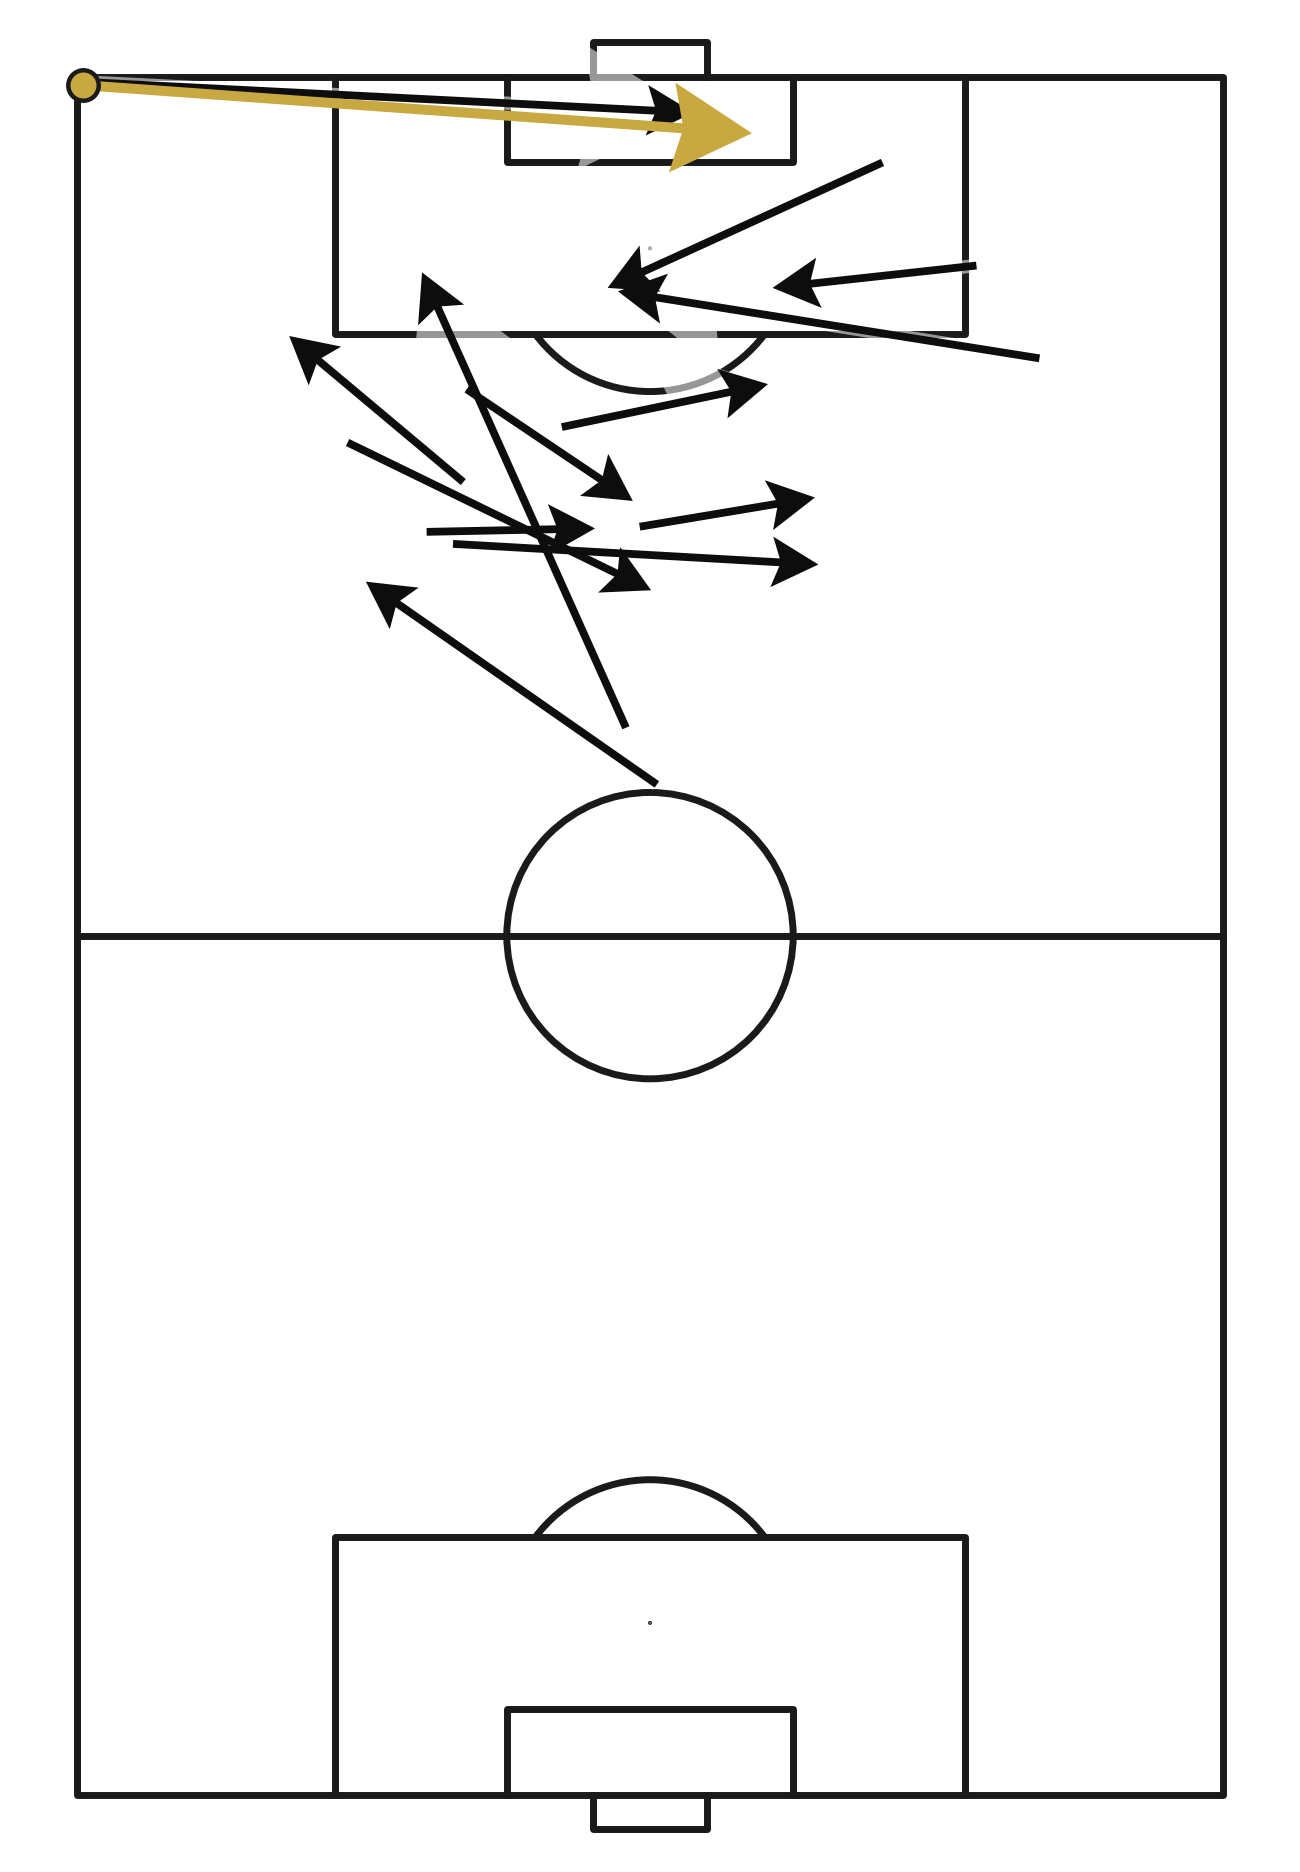

In [ ]:
"""
Cell — VERSION 3: Transparente · Heatmap + Pases + Líneas
==========================================================
Fondo completamente transparente (PNG con alpha).
  - Heatmap con alpha progresivo: zonas vacías = transparentes, zonas calientes = rojo opaco
  - Líneas de cancha: oscuras y visibles sobre cualquier fondo externo
  - Negro (#0D0D0D) → Key Passes
  - Dorado (#C8A840) → Asistencias

Uso: importar en Illustrator / Canva / template encima del diseño base.
     La marca de agua del fondo se ve a través del heatmap en zonas de baja densidad.

Exports → outputs/victor_felipe_mendez/vfm_key_passes_v3_transparent.png
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import VerticalPitch
from pathlib import Path

C_KP   = "#0D0D0D"    # key passes: negro
C_AST  = "#C8A840"    # asistencias: dorado
LINE_C = "#3A3A3A"    # líneas cancha: oscuro visible sobre cualquier fondo

_OUT = Path(r"c:\Users\PC\Projects\CaciqueAnalytics\outputs\victor_felipe_mendez")

# ── Colormap con alpha progresivo ──────────────────────────────────────────────
# Zonas de baja densidad → transparentes; zonas calientes → rojo opaco
N = 256
_base = LinearSegmentedColormap.from_list(
    "_base",
    [(0.00, "#E9E3D8"),
     (0.30, "#E8A878"),
     (0.58, "#C80014"),
     (0.80, "#9A000F"),
     (1.00, "#5A000A")],
    N=N,
)
_rgba = _base(np.linspace(0, 1, N))  # shape (256, 4)
# Alpha: 0 en el extremo bajo → 1.0 en el alto (curva cuadrática para suavizar)
_alpha_ramp = np.linspace(0, 1, N) ** 1.5
_rgba[:, 3] = _alpha_ramp

_hmap_alpha = LinearSegmentedColormap.from_list("cacique_heat_alpha", _rgba, N=N)

# ── Figura y pitch completamente transparentes ────────────────────────────────
fig = plt.figure(figsize=(7, 10.5), dpi=200, facecolor="none")
fig.patch.set_alpha(0.0)

ax_pitch = fig.add_axes([0.05, 0.05, 0.90, 0.90])
ax_pitch.set_facecolor("none")
ax_pitch.patch.set_alpha(0.0)

pitch = VerticalPitch(
    pitch_type="statsbomb",
    pitch_color="none",
    line_color=LINE_C,
    line_zorder=2,
    line_alpha=1.0,
    linewidth=2.0,
    half=False,
    spot_scale=0.004,
    goal_type="box",
)
pitch.draw(ax=ax_pitch)

# ── Heatmap con alpha progresivo ──────────────────────────────────────────────
pitch.kdeplot(
    df_all_pos["x"], df_all_pos["y"],
    ax=ax_pitch,
    cmap=_hmap_alpha,
    fill=True,
    levels=10,
    alpha=1.0,        # el alpha lo maneja el colormap directamente
    zorder=1,
)

# ── Key Passes: negro ─────────────────────────────────────────────────────────
_kp_only = df_passes[df_passes["type"] == "Key Pass"]
if not _kp_only.empty:
    pitch.arrows(
        _kp_only["x"], _kp_only["y"], _kp_only["end_x"], _kp_only["end_y"],
        ax=ax_pitch, color=C_KP, alpha=0.95,
        width=2.6, headwidth=6.5, headlength=6.0, headaxislength=5.0, zorder=4,
    )

# ── Assist: dorado ────────────────────────────────────────────────────────────
_ast = df_passes[df_passes["type"] == "Assist"]
if not _ast.empty:
    pitch.scatter(
        _ast["x"], _ast["y"],
        ax=ax_pitch, s=120, c=C_AST, marker="o",
        edgecolors="#1A1A1A", linewidths=1.6, zorder=6, alpha=1.0,
    )
    pitch.arrows(
        _ast["x"], _ast["y"], _ast["end_x"], _ast["end_y"],
        ax=ax_pitch, color=C_AST, alpha=1.0,
        width=3.4, headwidth=8.5, headlength=7.5, headaxislength=6.5, zorder=5,
    )

_out_v3 = _OUT / "vfm_key_passes_v3_transparent.png"
fig.savefig(
    _out_v3,
    dpi=200,
    bbox_inches="tight",
    transparent=True,
    facecolor="none",
)
print(f"Saved → {_out_v3}")
try:
    from PIL import Image as _I
    with _I.open(_out_v3) as _im:
        print(f"  Size: {_im.size[0]} x {_im.size[1]} px  mode={_im.mode}")
        has_alpha = _im.mode in ("RGBA", "LA") or "transparency" in _im.info
        print(f"  Alpha channel: {has_alpha}")
except Exception:
    pass
plt.show()
